In [2]:
import itertools
from operator import imod
import warnings
import pandas as pd
import numpy as np
from random import gauss

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess

from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

import os
from IPython.display import Image

from pmdarima import auto_arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

from prophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
class CFG:
    img_dim1 = 20
    img_dim2 = 10

plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

## AR Processes

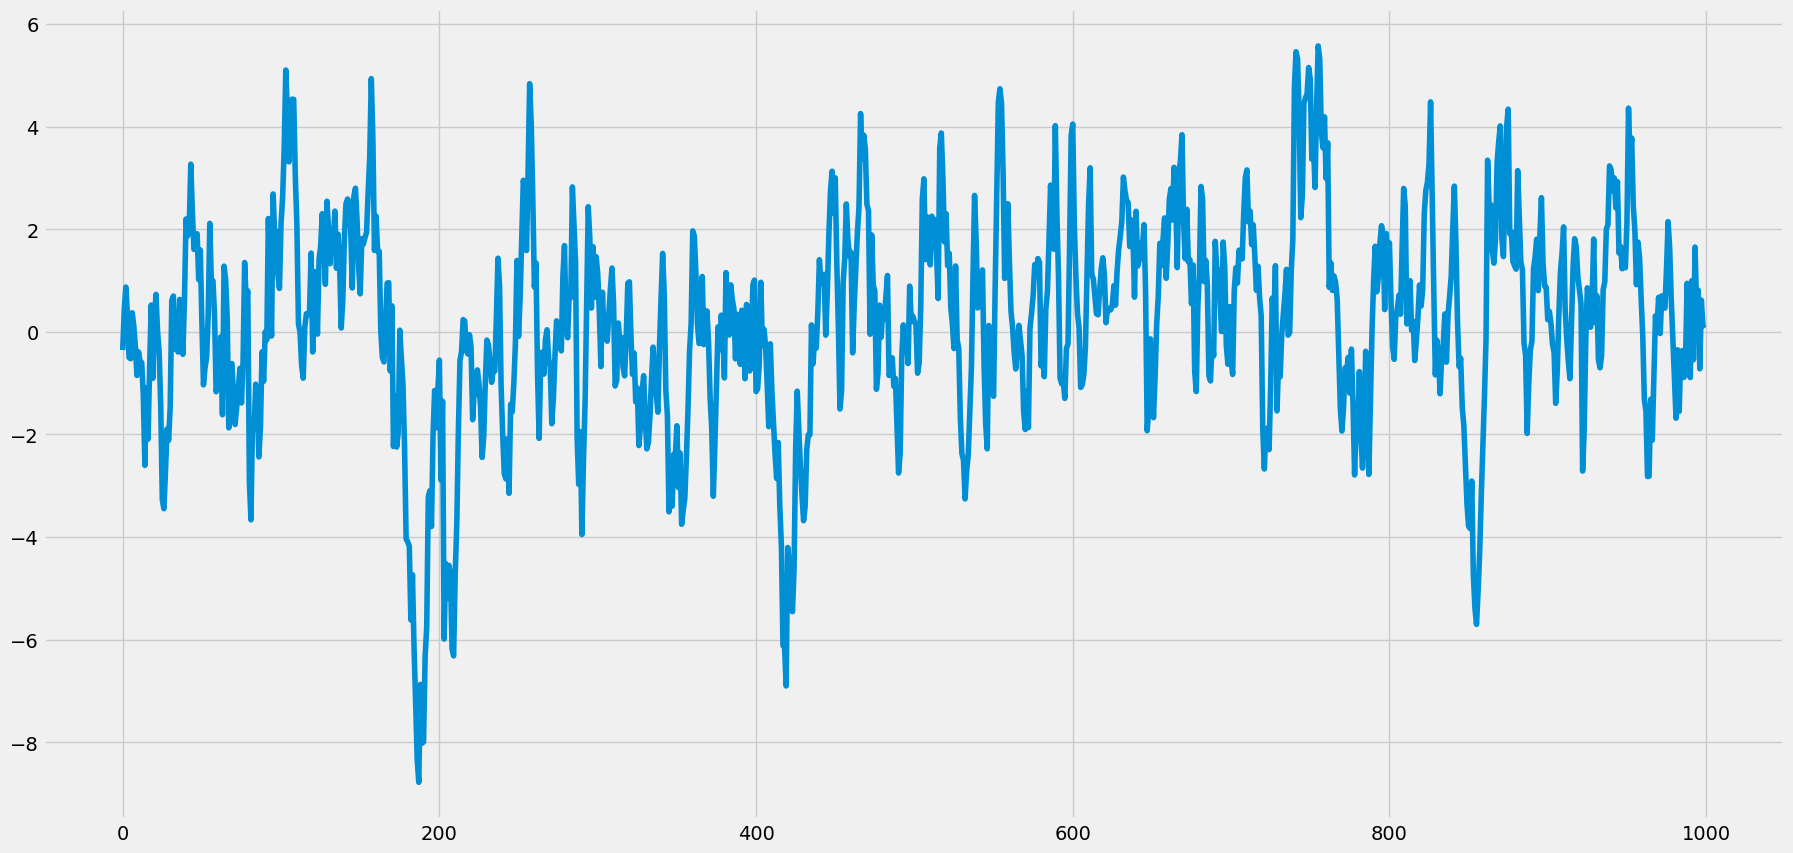

In [4]:
ar1 = np.array([1.0, -0.9])
ma1 = np.array([1.0])

AR_object1 = ArmaProcess(ar1, ma1)
simulated_data1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data1)
plt.show()

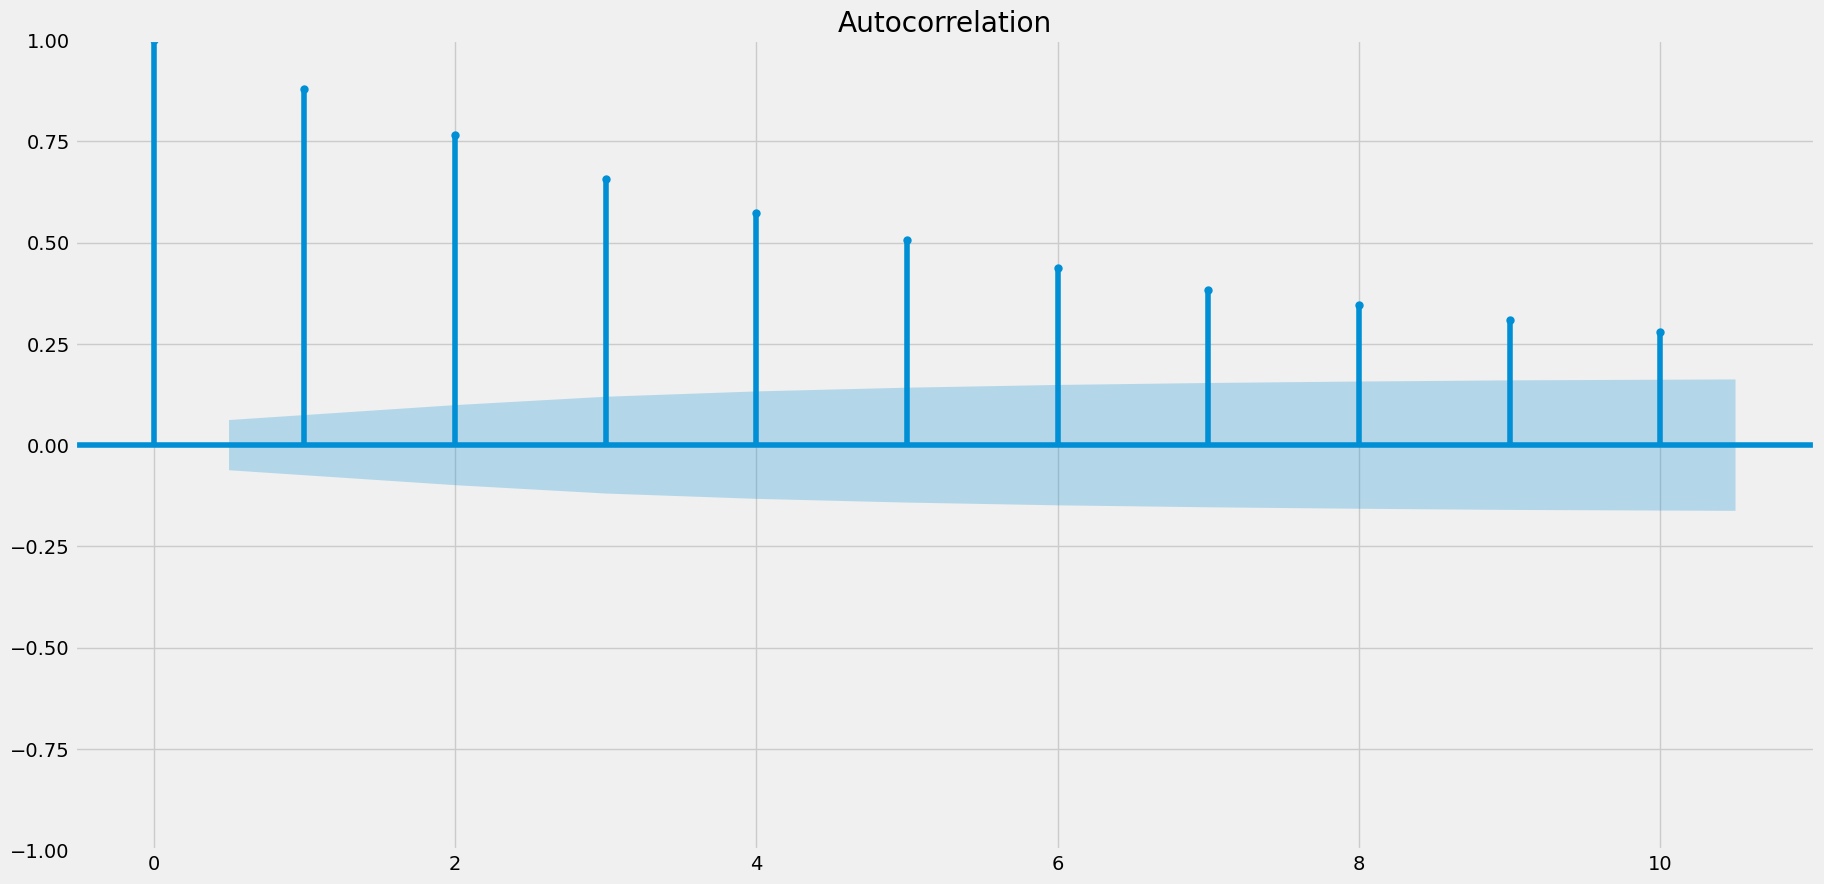

In [5]:
plot_acf(simulated_data1, lags=10)
plt.show()

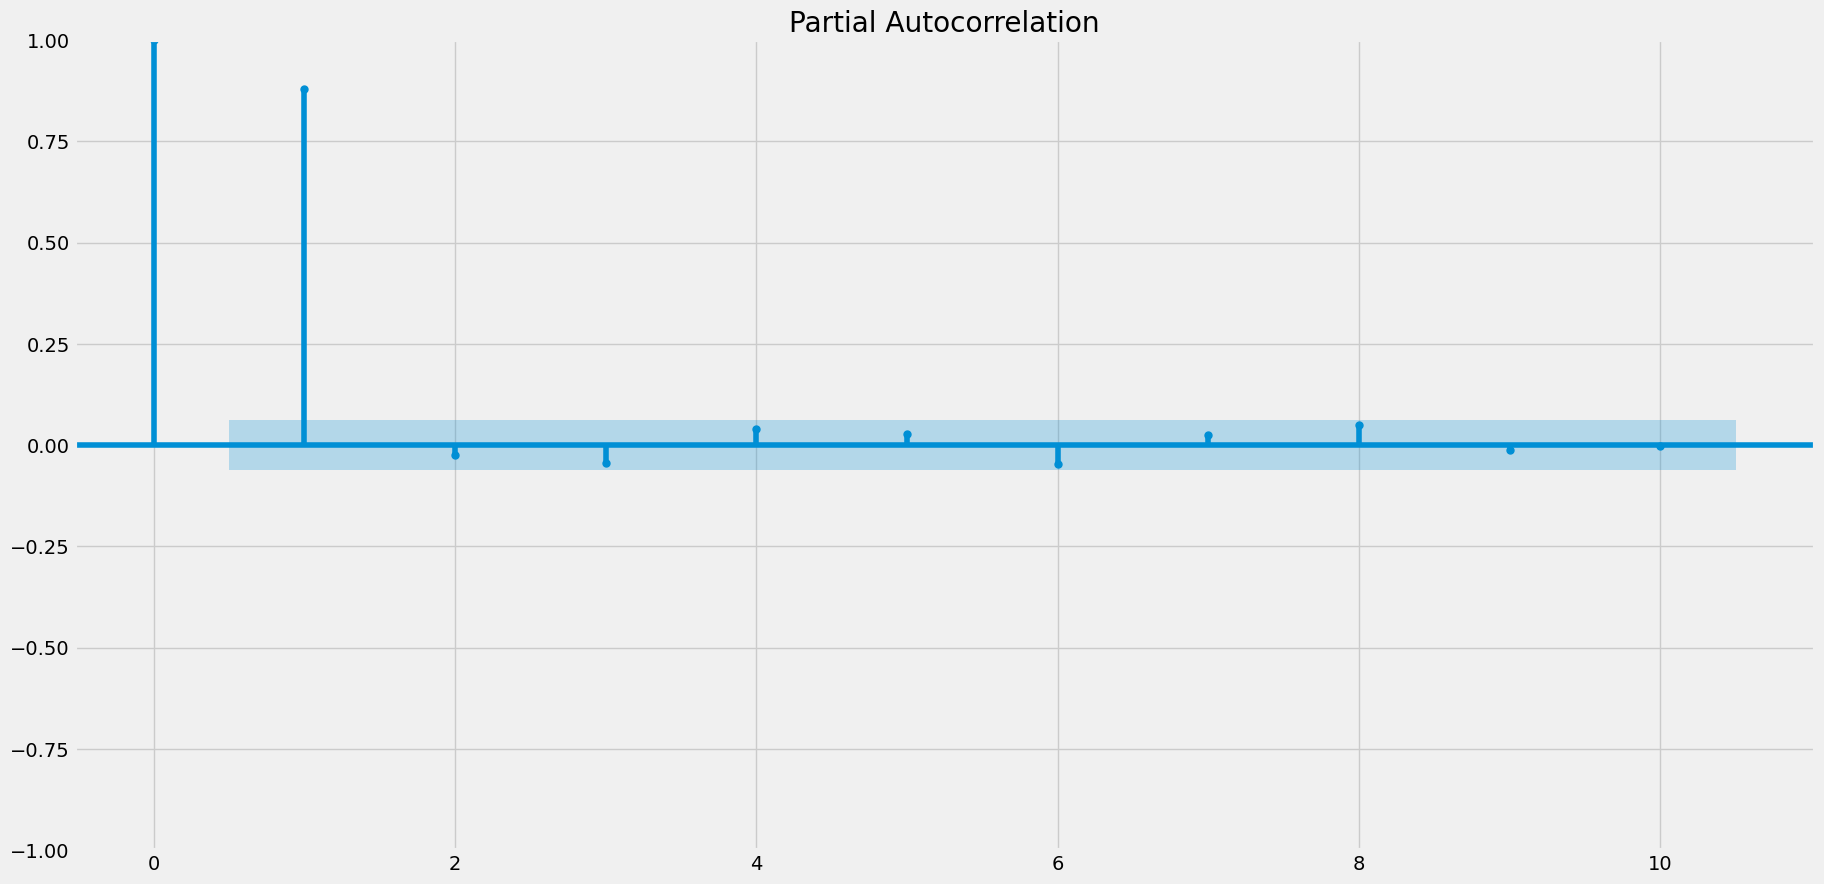

In [6]:
plot_pacf(simulated_data1, lags=10)
plt.show()

### MA : Moving Average Process

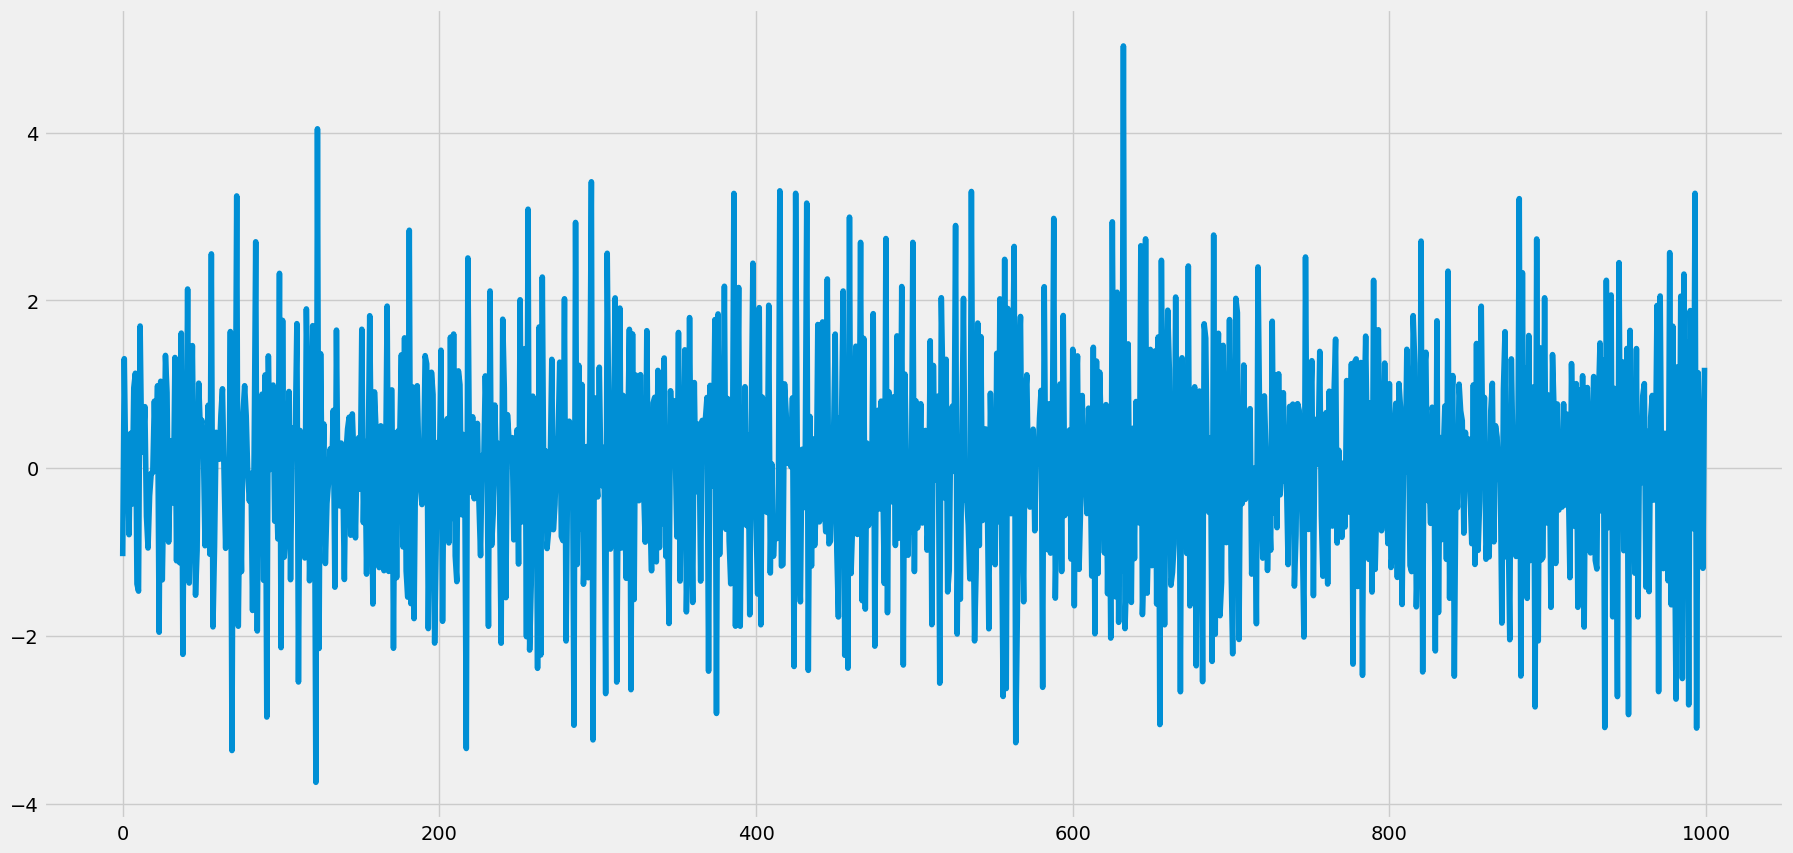

In [7]:
ar1 = np.array([1.0])
ma1 = np.array([1.0, -0.9])

MA_object1 = ArmaProcess(ar1, ma1)
simulated_data1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data1)
plt.show()

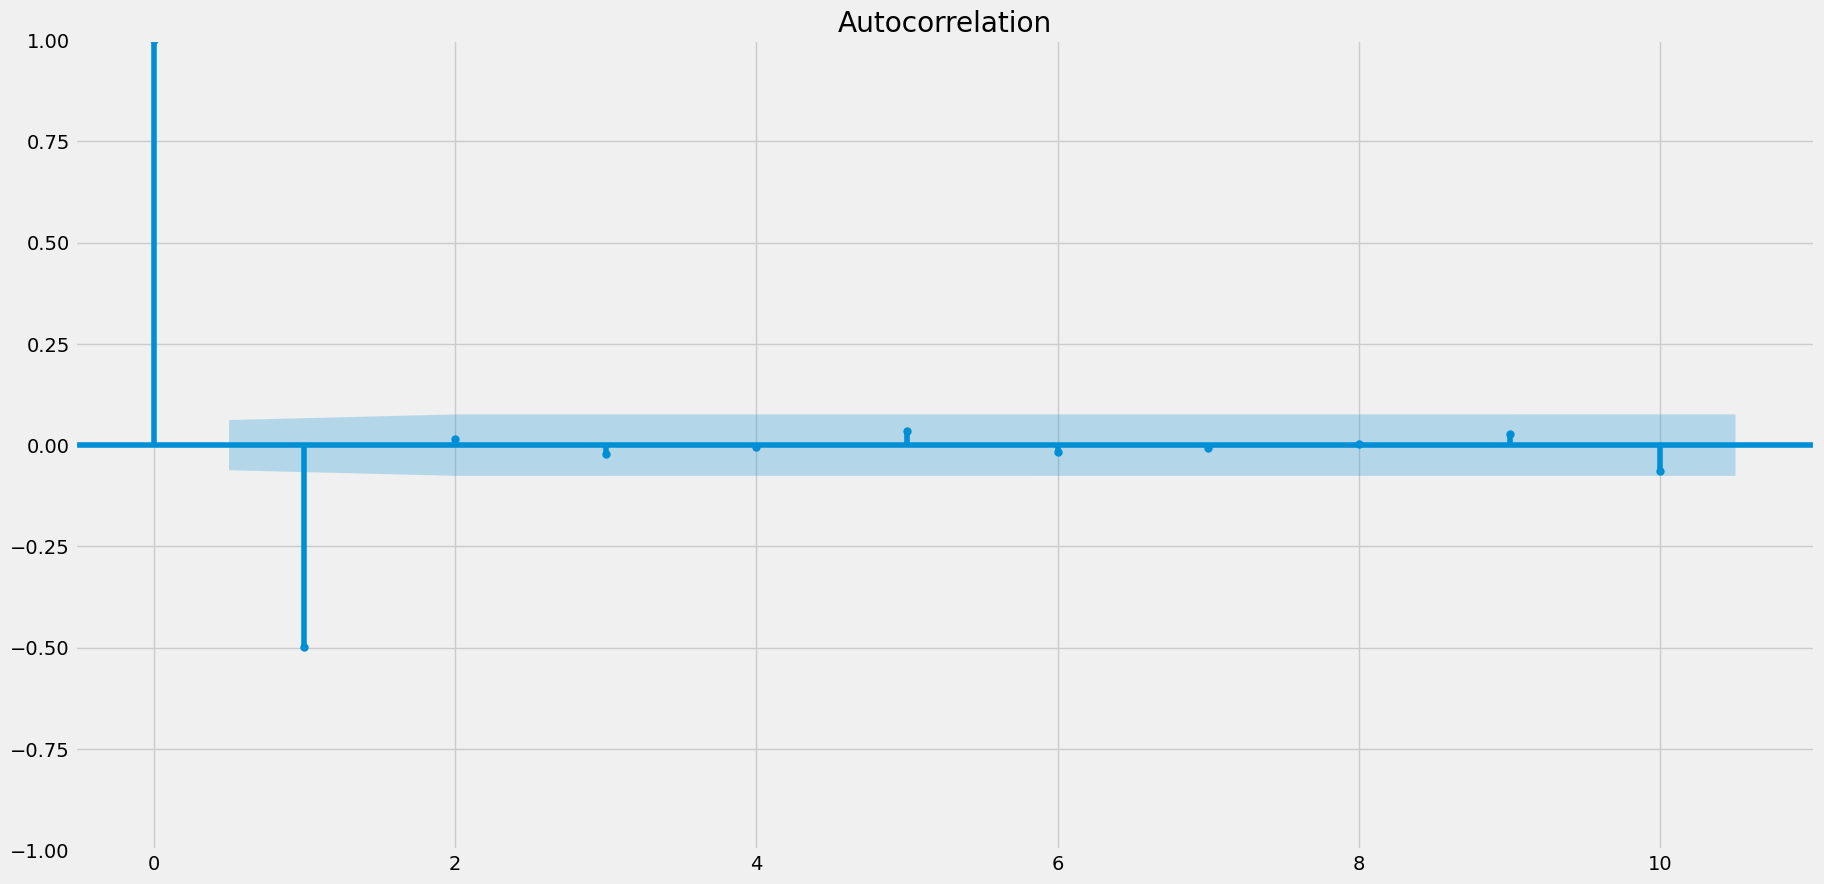

In [8]:
plot_acf(simulated_data1, lags=10)
plt.show()

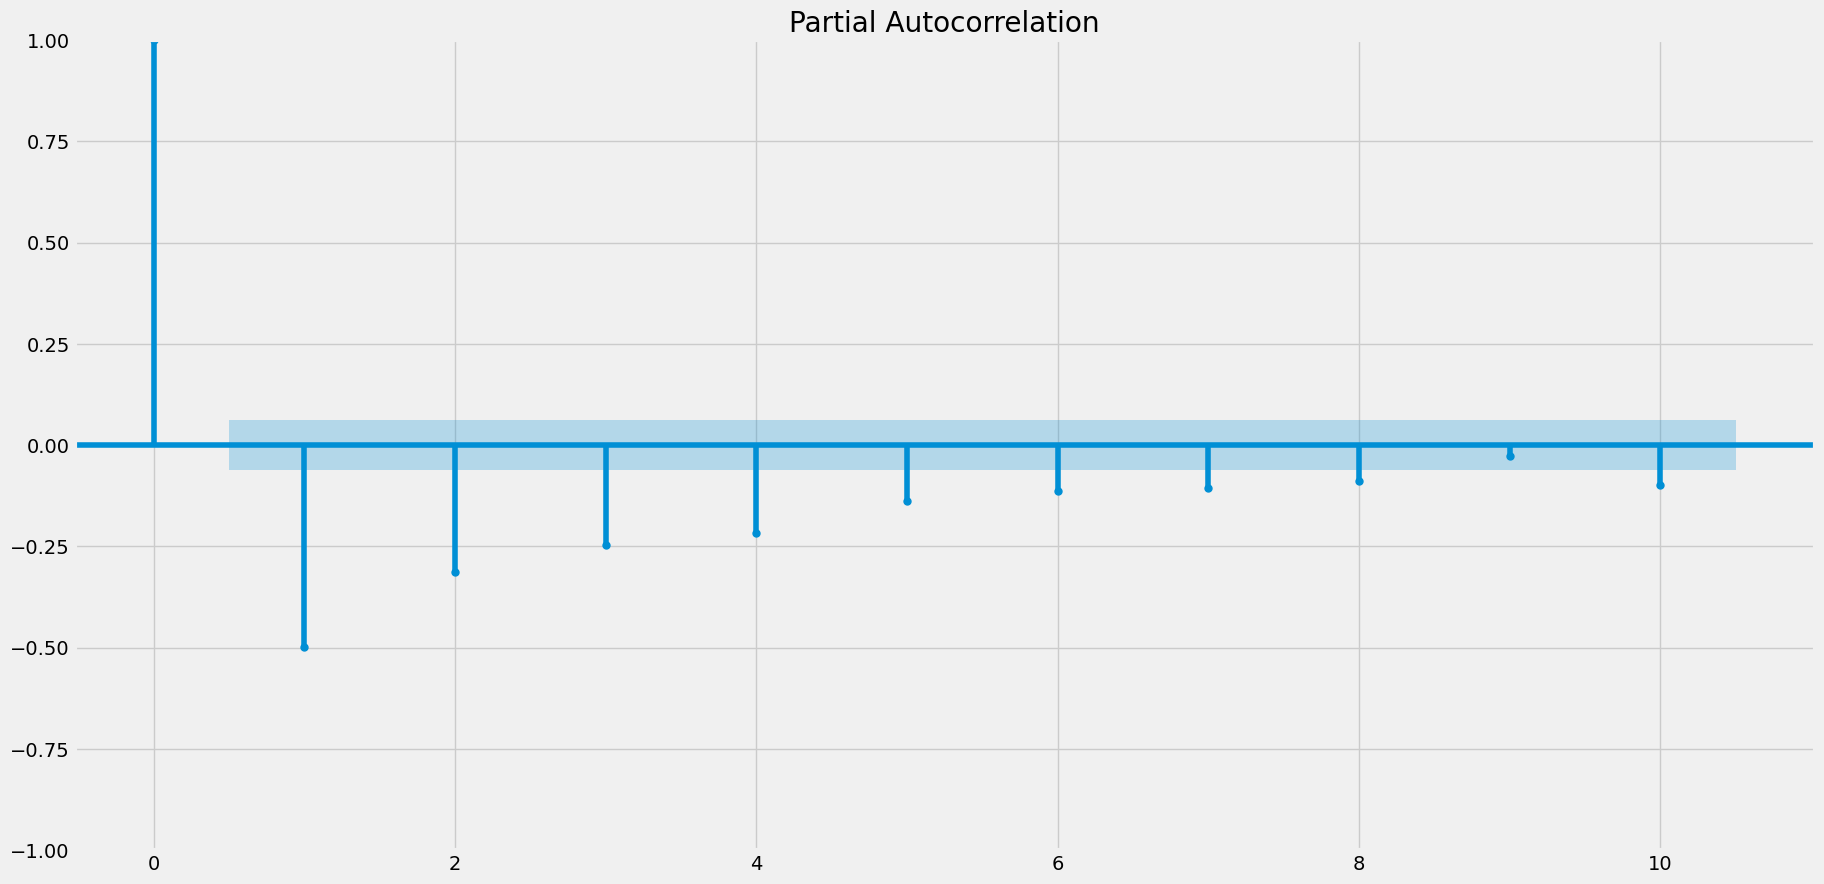

In [10]:
plot_pacf(simulated_data1, lags=10)
plt.show()

Intuition to identify AR Process
- process memory: direct and indirect dependence information
- ACF for AR(p): strong until lag p, trailing off afterwards
- PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.
- analytical derivation is based on the Laurent series expansion and the backshift operator  𝐵 

Intuition for identify MA Process:
- MA model corrects future forecasts based on errors made on recent forecasts.
- ACF for MA(k) series: to show a strong correlation with recent values up to the lag of k, then a sharp decline
- PACF: strong relationship to the lag k and a trailing off of correlation from the lag onwards.

### ARMA : AutoRegressive Moving Average Process  

Process Params: p, q  
p: order of autoregressive part  
q: order of moving average part  

<AxesSubplot: xlabel='date'>

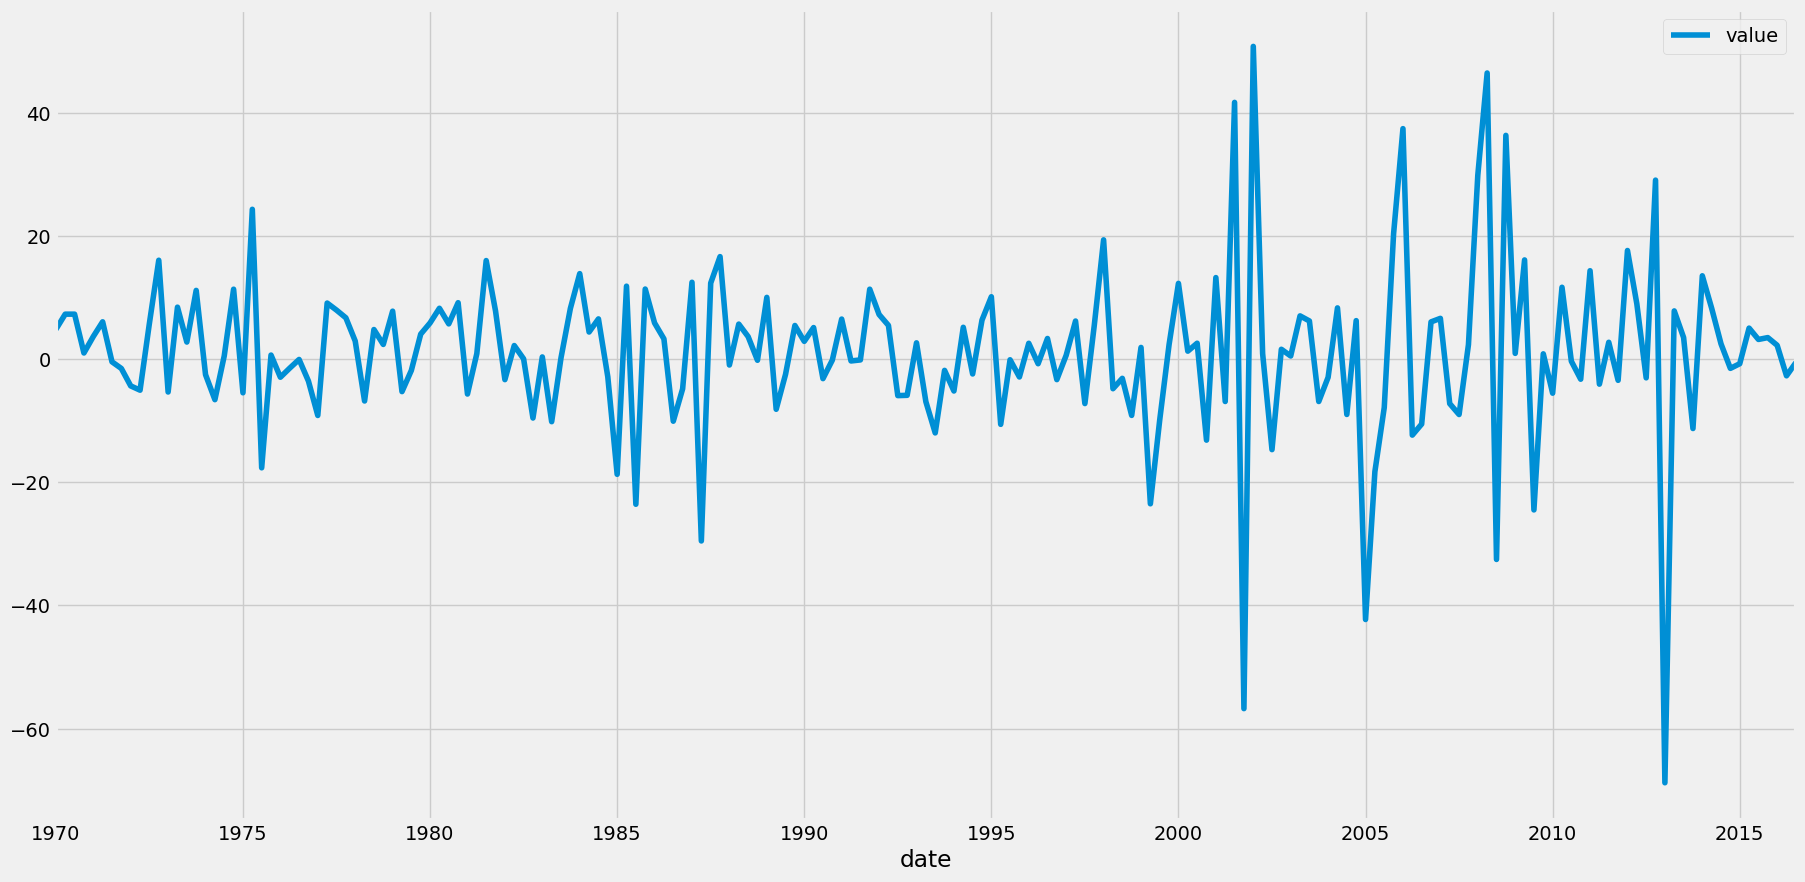

In [12]:
xdat = pd.read_csv("datasets/savings_change.csv")
xdat.columns = ["date", "value"]
xdat["date"] = pd.to_datetime(xdat["date"])
xdat.set_index('date').plot()

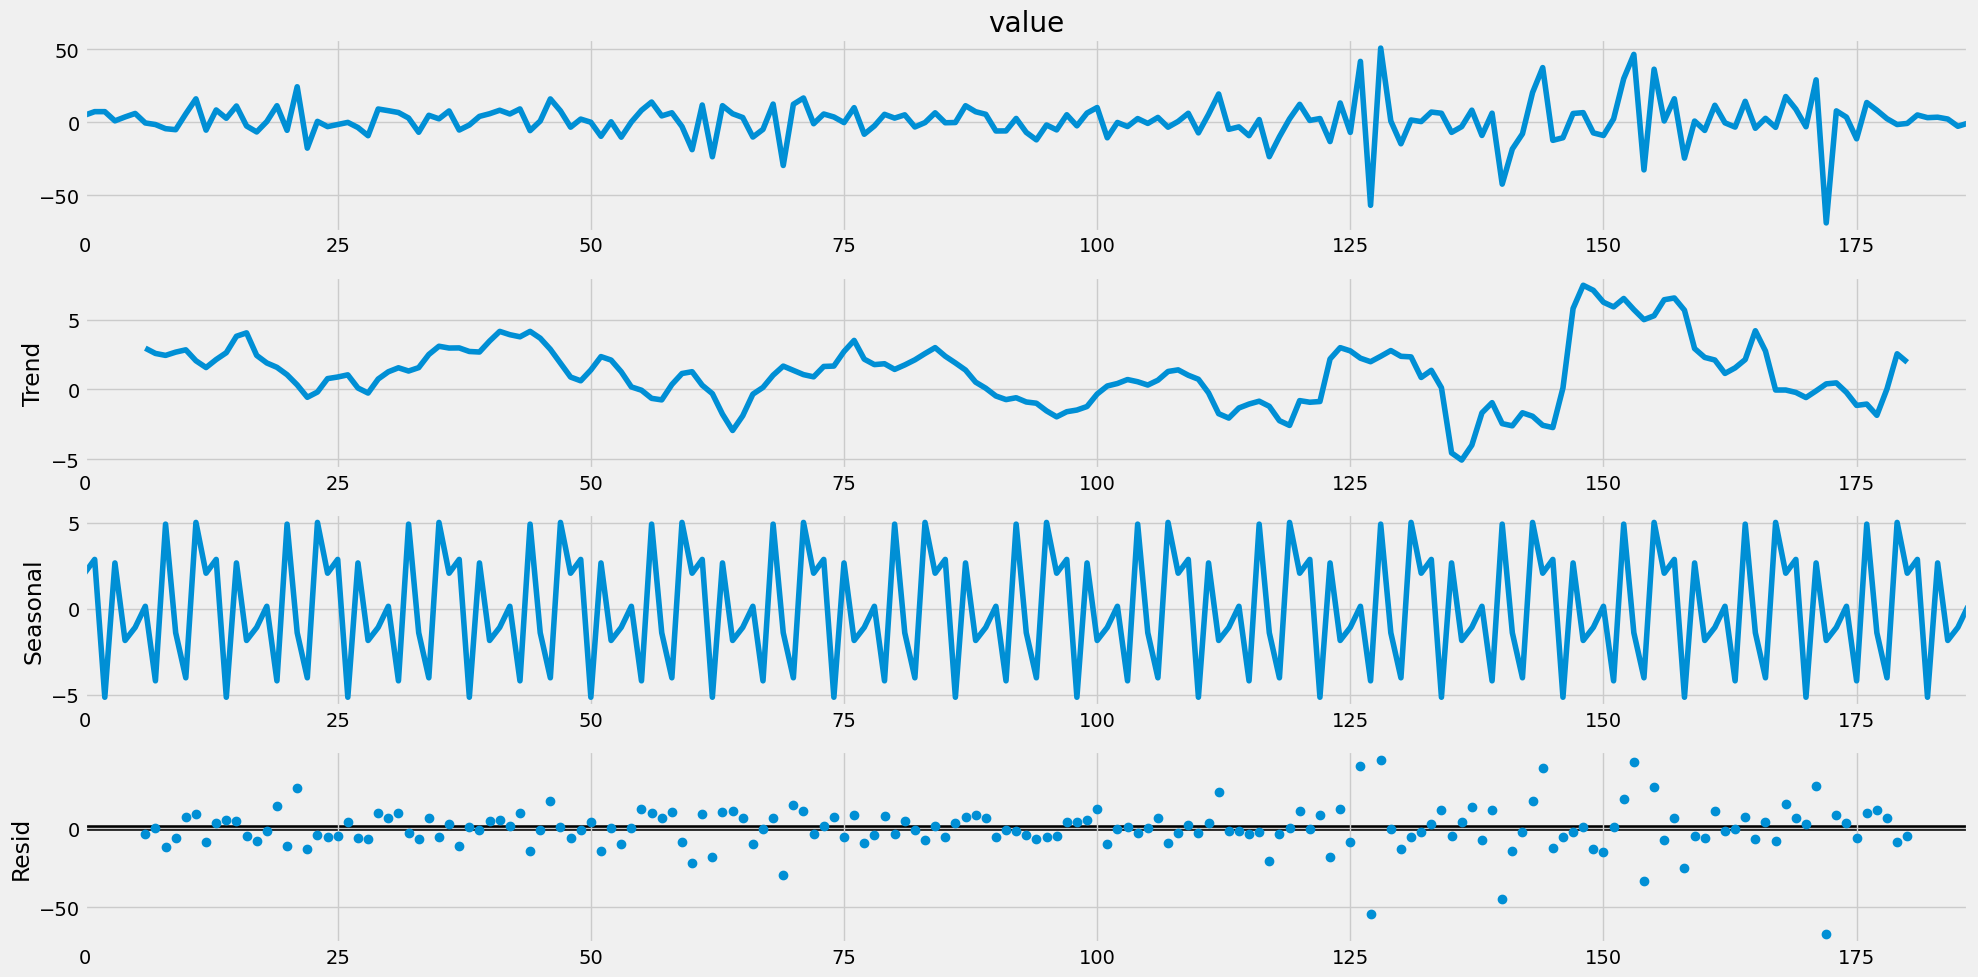

In [13]:
decomposition = seasonal_decompose(xdat["value"], period=12, model="additive")
figure = decomposition.plot()
plt.show()

In [18]:
result = adfuller(xdat["value"])
print('ADF Statistic: %f' % result[0])
print('p Statistic: %f' % result[1])

ADF Statistic: -18.705760
p Statistic: 0.000000


p value < 0.05 imples stationary process

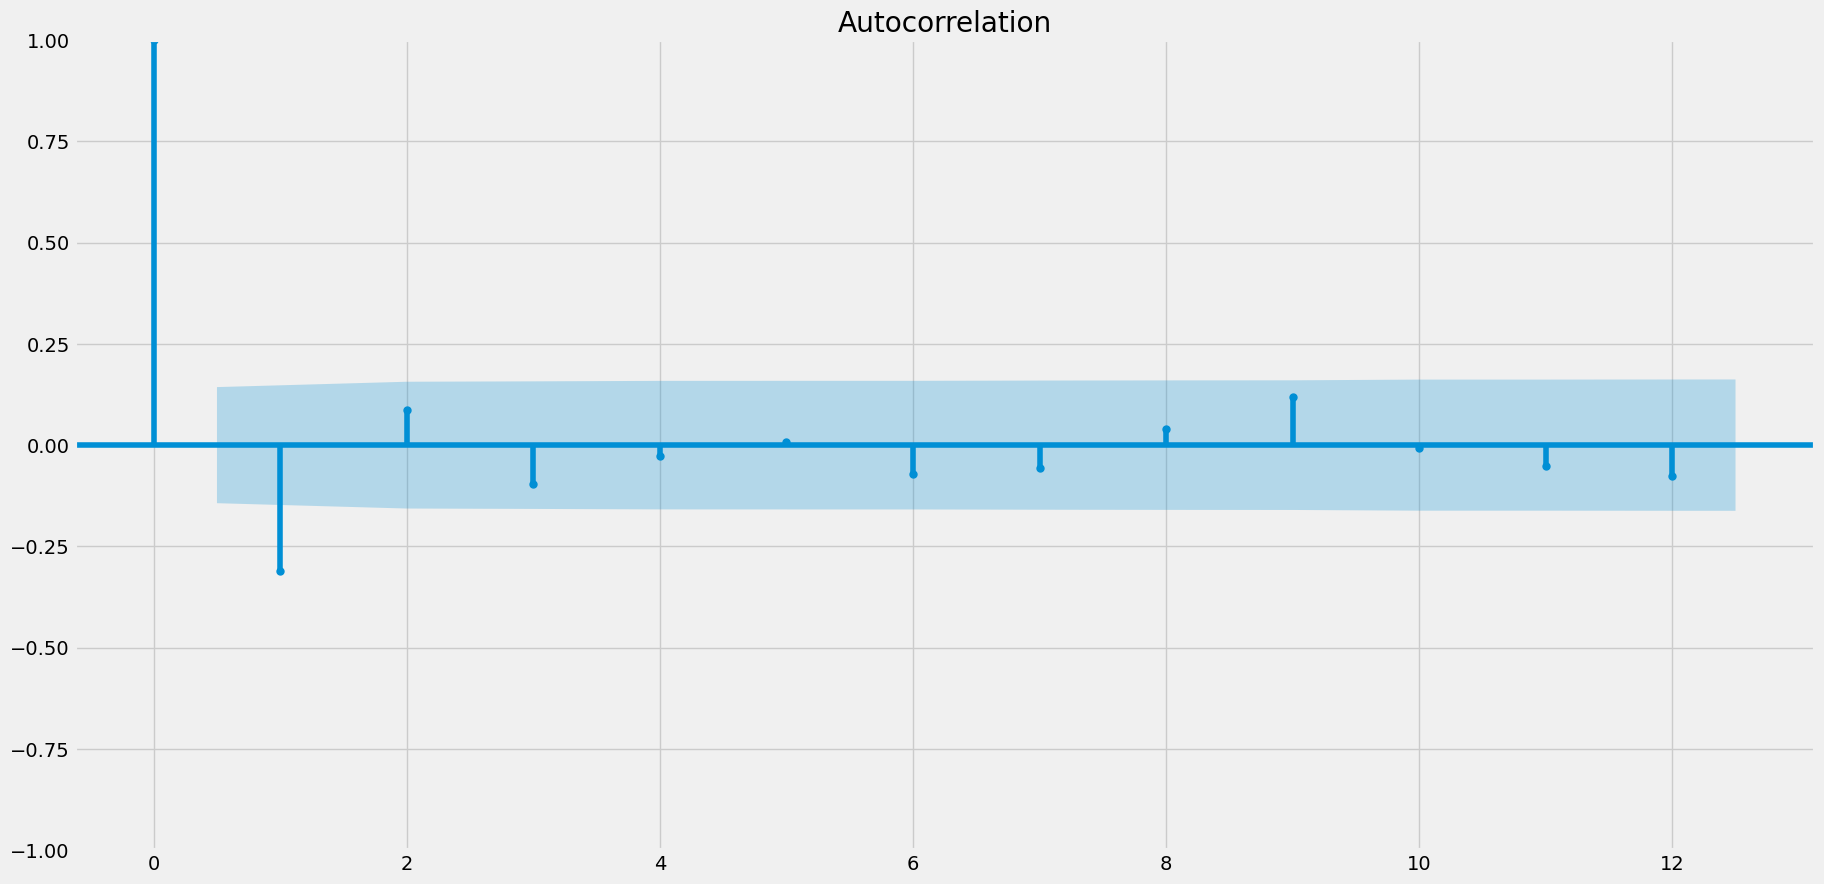

In [16]:
plot_acf(xdat['value'], lags=12)
plt.show()

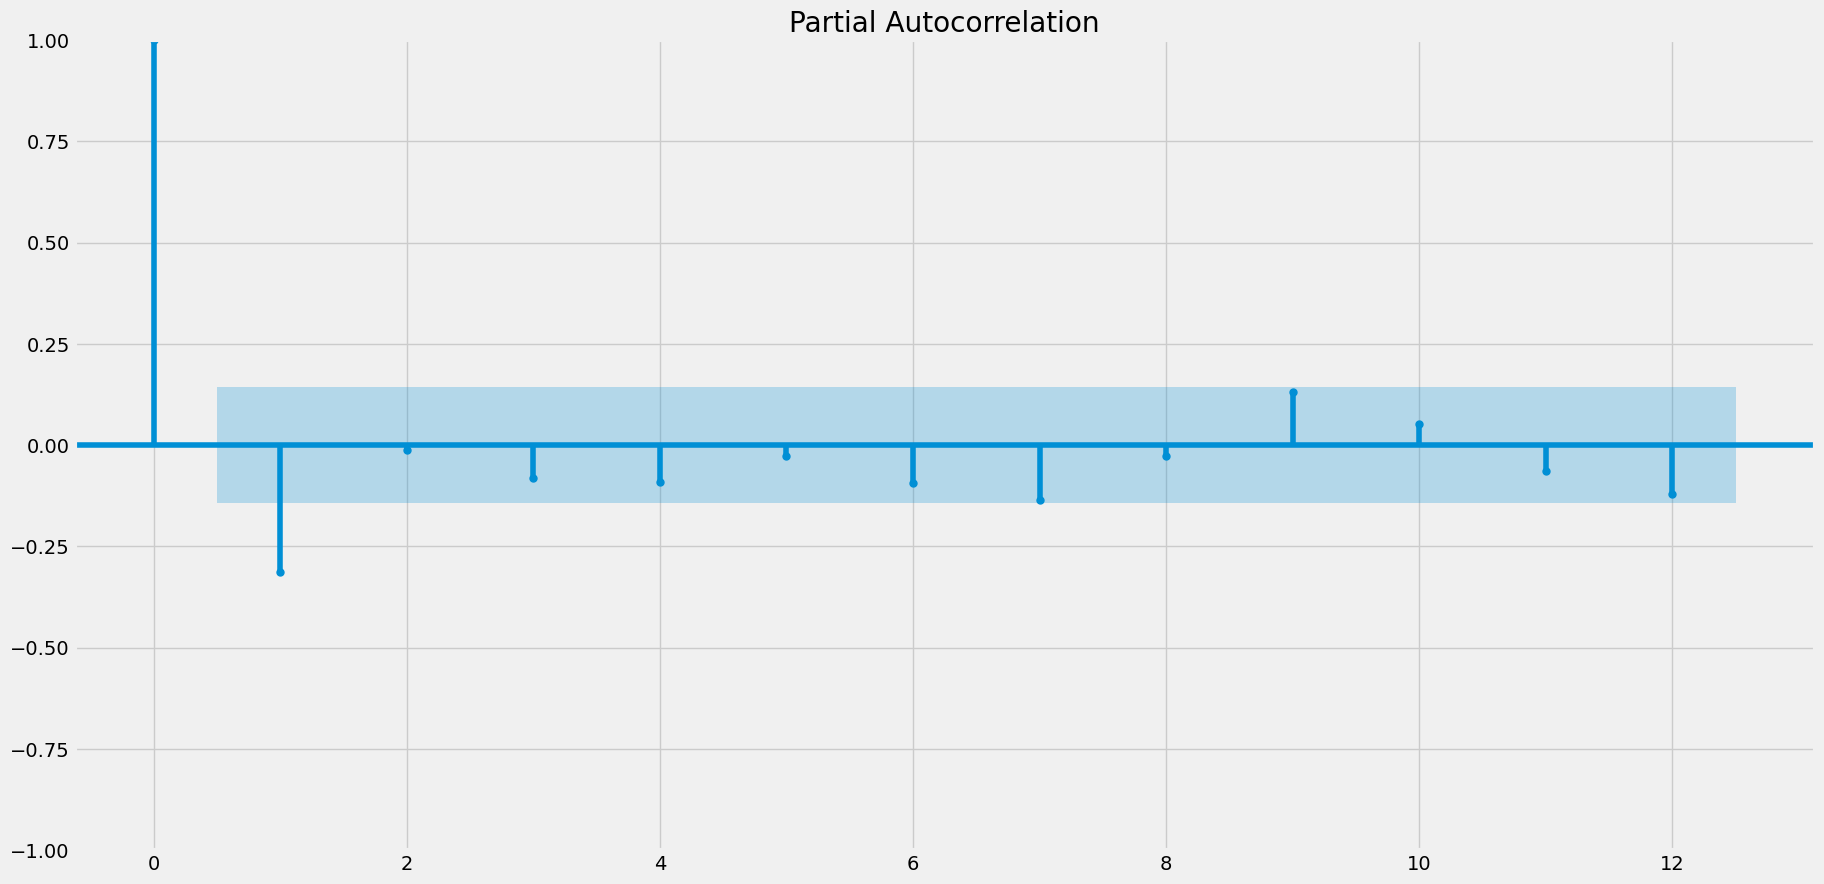

In [17]:
plot_pacf(xdat['value'], lags=12)
plt.show()

In [20]:
xtrain, xvalid = model_selection.train_test_split(xdat["value"], test_size=12)

In [21]:
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action='ignore', seasonal=False, suppress_warnings="False"))
])

pipe.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1417.652, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1428.604, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1413.626, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1414.732, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1415.564, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1415.511, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1417.401, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1413.240, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1429.318, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1415.233, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1415.223, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1413.866, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1417.096, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.478 seconds


Pipeline(steps=[('fourier', FourierFeaturizer(m=4)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False,
                           suppress_warnings='False', trace=1))])

In [22]:
pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  175
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -699.620
Date:                Tue, 25 Oct 2022   AIC                           1413.240
Time:                        19:18:27   BIC                           1435.394
Sample:                             0   HQIC                          1422.226
                                - 175                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.5503      1.091      1.421      0.155      -0.588       3.689
FOURIER_S4-0     2.2632      1.465      1.545      0.122      -0.609       5.135
FOURIER_C4-0     0.6652      1.497      0.444      0.657      -2.268       3.599
FOURIER_S4-1  9.682e+04   3.97e+05      0.244      0.808   -6.82e+05    8.76e+05
FOURIER_C4-1    -0.0559      4.481     -0.012      0.990      -8.839       8.727
ar.L1           -0.3125      0.043     -7.312      0.000      -0.396      -0.229
sigma2         173.6642     11.068     15.691      0.000     151.972     195.357
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               206.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.35   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
preds, conf_int = pipe.predict(n_periods=xvalid.shape[0], return_conf_int=True)
print("\nForecasts: ")
print(preds)


Forecasts: 
175    1.404690
176    2.588137
177    1.783539
178   -2.484031
179    3.296285
180    1.973680
181    1.998851
182   -2.574599
183    3.347867
184    1.934282
185    2.034440
186   -2.608998
dtype: float64


In [24]:
conf_int

array([[-24.4240525 ,  27.23343317],
       [-24.47263541,  29.64890921],
       [-25.3945784 ,  28.96165593],
       [-29.67358287,  24.70552051],
       [-23.89438331,  30.48695329],
       [-25.21709748,  29.16445725],
       [-25.19193681,  29.18963922],
       [-29.76538836,  24.61618976],
       [-23.842922  ,  30.53865632],
       [-25.25650673,  29.12507161],
       [-25.15634905,  29.22522929],
       [-29.79978755,  24.58179079]])

<AxesSubplot: >

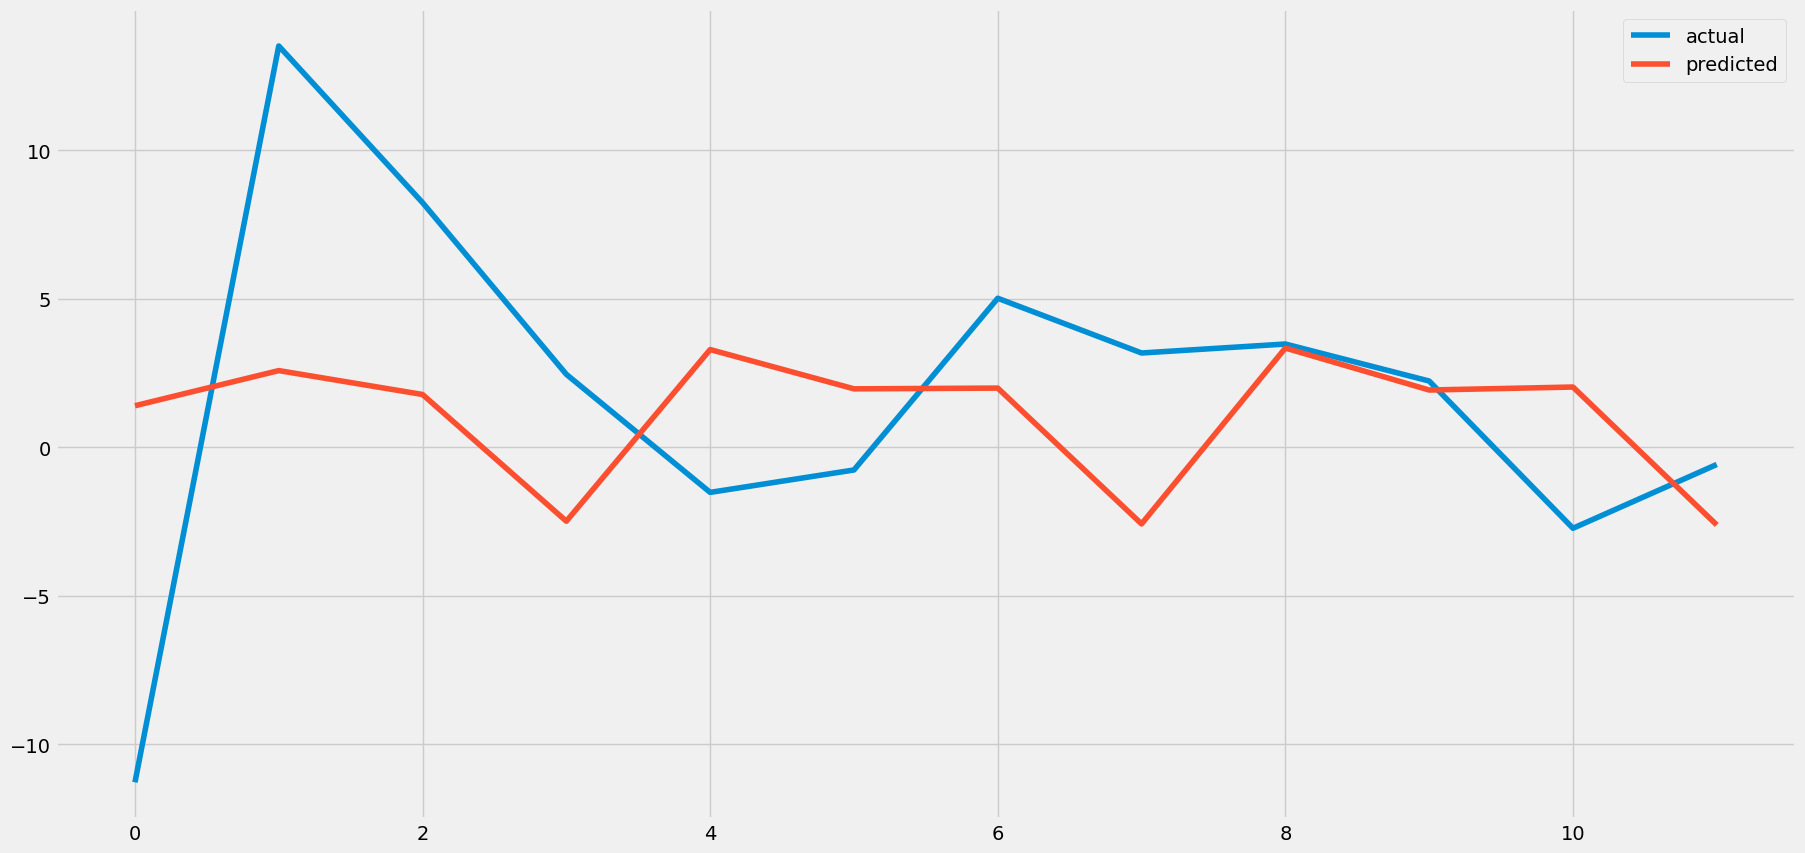

In [29]:
xvalid = pd.DataFrame(xvalid.actual, columns=['actual'])
xvalid['predicted'] = preds.values
xvalid.plot()

### ARIMA: 
Process Params: p, q, d  
p: order of autoregressive part  
q: order of moving average part  
d: series behave as stationary after differencing it d times  

In [28]:
ARIMA

,actual
0,-11.276615
1,13.520202
2,8.244048
3,2.461953
4,-1.513050
5,-0.758400
6,5.023918
7,3.180930
8,3.482786
9,2.236534


<AxesSubplot: xlabel='date'>

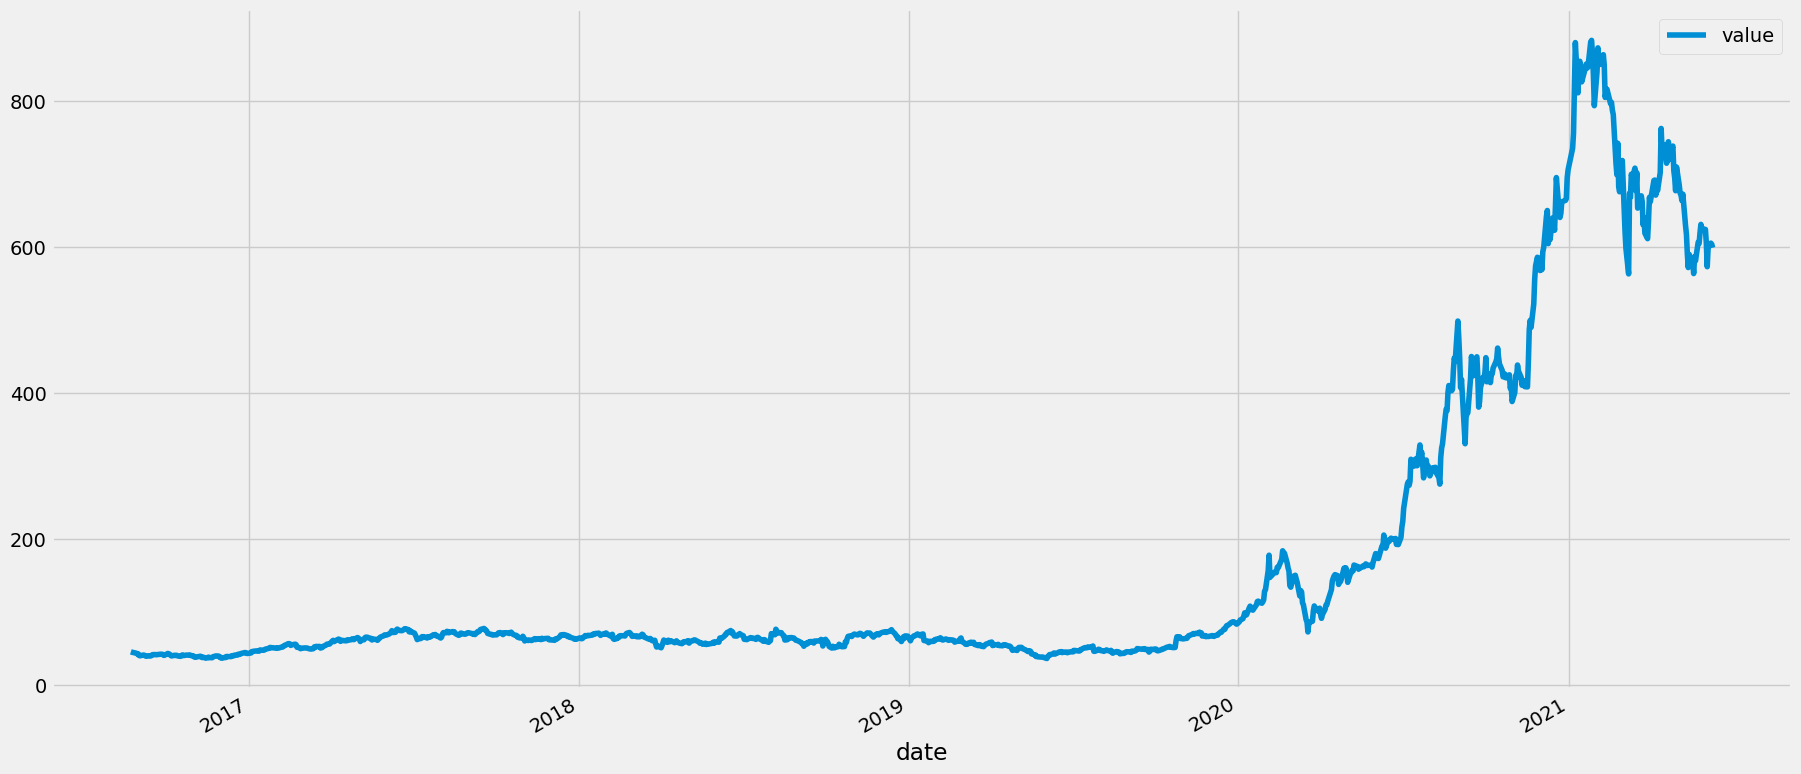

In [32]:
xdat = pd.read_csv("datasets/tesla_prices_5y.csv")
xdat = xdat[["Date", "Close"]]
xdat["date"] = pd.to_datetime(xdat["Date"])
xdat["value"] = xdat["Close"]
xdat = xdat[["date", "value"]]
xdat.set_index("date").plot()

In [35]:
result = adfuller(xdat["value"])
print("p-value: ", result[1])

p-value:  0.9357240265130836


<AxesSubplot: >

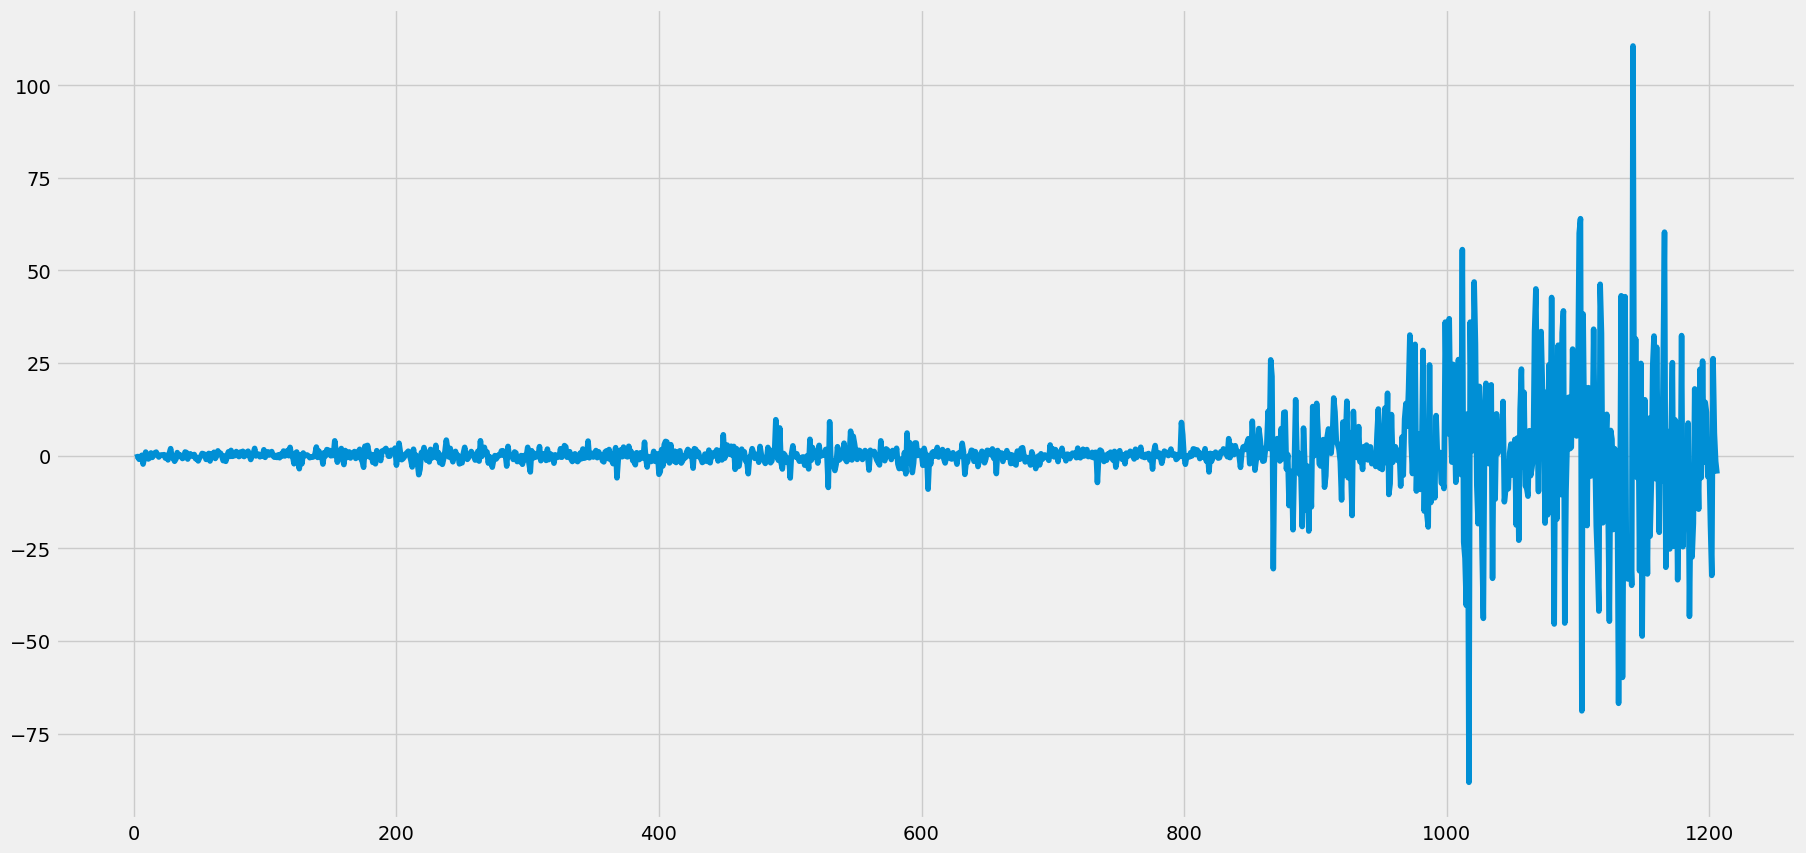

In [36]:
ydat = xdat["value"].diff()
ydat.plot()

In [37]:
result = adfuller(ydat.dropna())
print("p-value: ", result[1])

p-value:  2.269333818910396e-07


### SARIMA:  
Seasonal ARIMA
Parameters: p, d, q for ARIMA part
Params: P, D, Q for seasonal part

A good intuition to think about is that we want to identify components of the seasonal part the way we would for the series itself:
- we isolate the seasonal component, e.g. through seasonal decomposition  
- to establish the value of  𝐷  we test the seasonal component - is it stationary? is the differenced version stationary?  
- the seasonal autoregressive value  𝑃  can be established by inspecting the PACF of the seasonal component  
- the seasonal moving average value  𝑄  can be established by inspect the ACF of the seasonal component


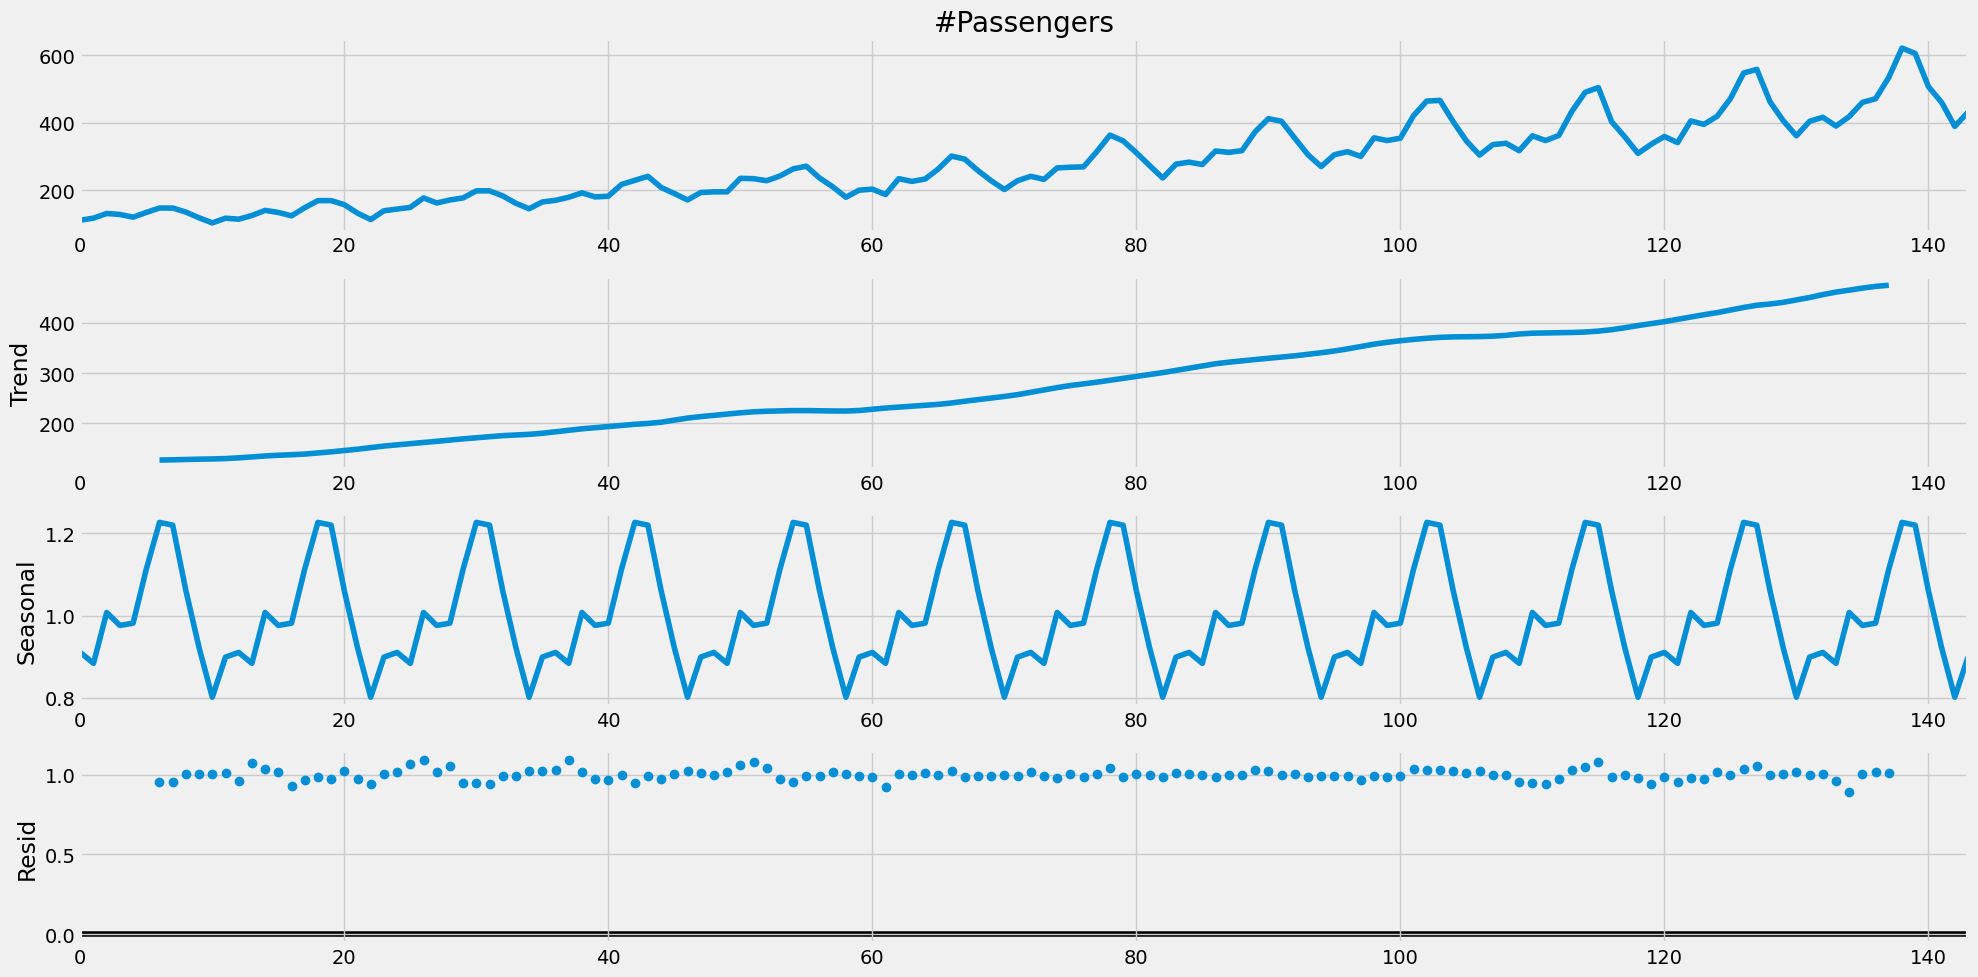

In [42]:
series = pd.read_csv("datasets/AirPassengers.csv")
series["date"] = pd.to_datetime(series["Month"])

decomposition = seasonal_decompose(series['#Passengers'], period=12, model='multiplicative')
figure = decomposition.plot()
plt.show()

In [43]:
result = adfuller(decomposition.seasonal)
print("p-value: ", result[1])

p-value:  0.0


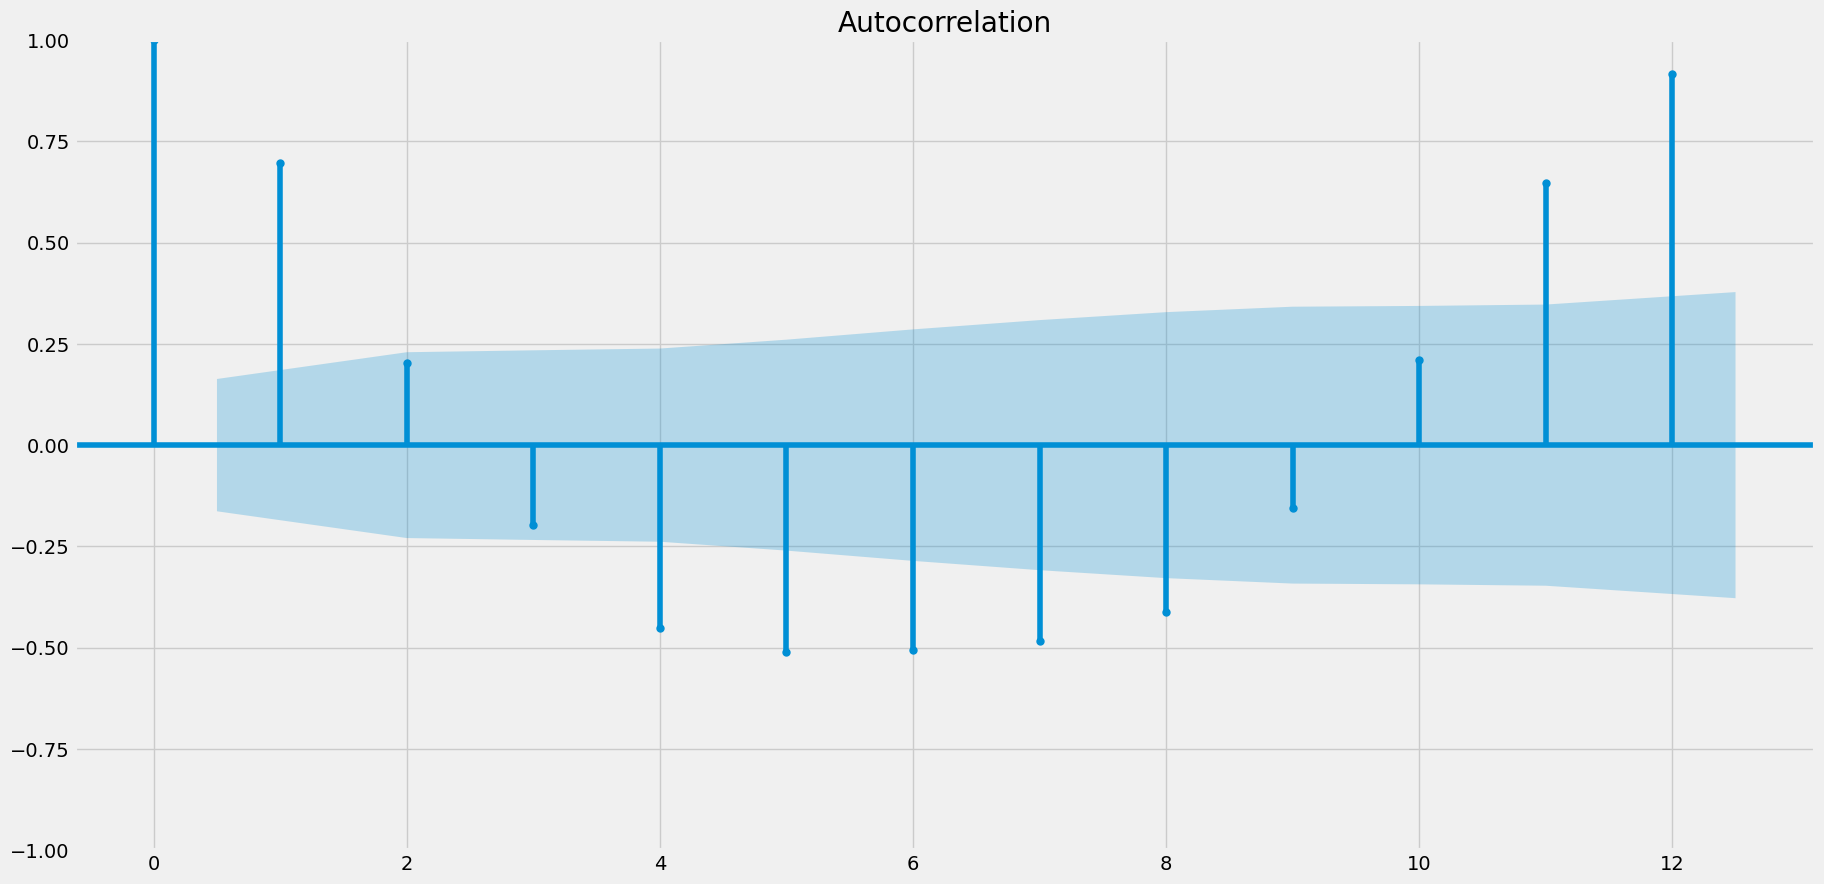

In [44]:
plot_acf(decomposition.seasonal, lags=12)
plt.show()

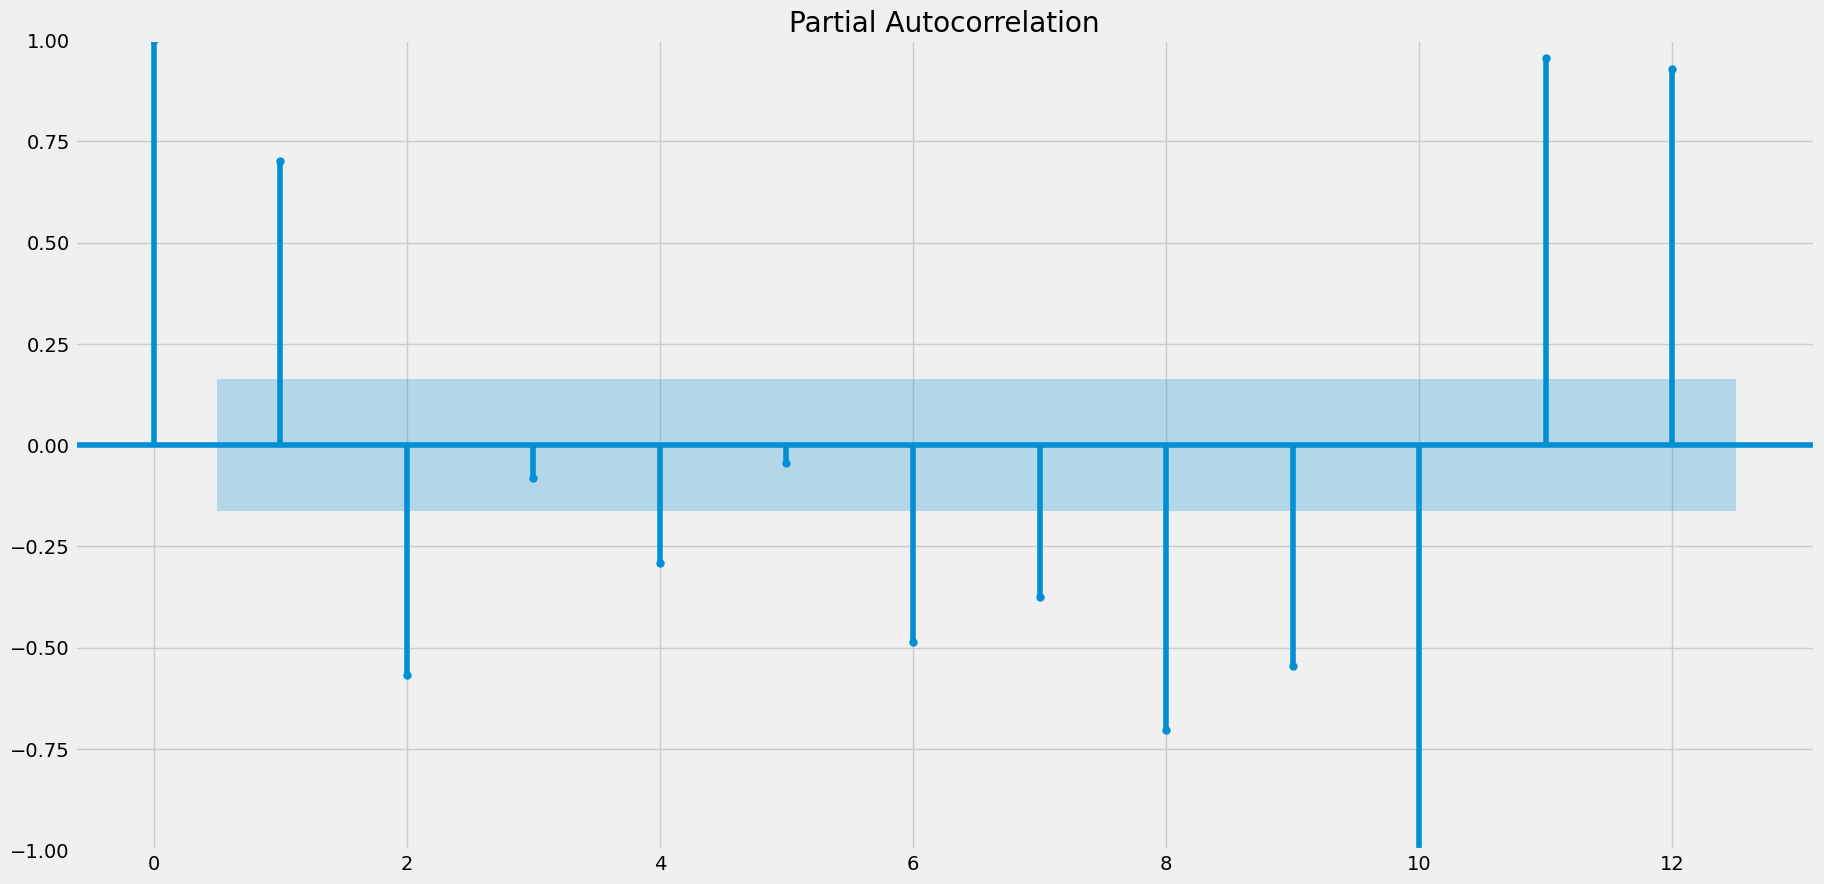

In [45]:
plot_pacf(decomposition.seasonal, lags=12)
plt.show()

### Demand Forecasting Example

In [46]:
train_df = pd.read_csv('datasets/demand_train.csv', parse_dates=['date'], index_col='date')
test_df  = pd.read_csv('datasets/demand_test.csv', parse_dates=['date'], index_col='date')
df = pd.concat([train_df, test_df], sort=True)
df

,id,item,sales,store
date,,,,
2013-01-01,NaN,1,13.0,1
2013-01-02,NaN,1,11.0,1
2013-01-03,NaN,1,14.0,1
2013-01-04,NaN,1,13.0,1
2013-01-05,NaN,1,10.0,1
...,...,...,...,...
2018-03-27,44995.0,50,NaN,10
2018-03-28,44996.0,50,NaN,10
2018-03-29,44997.0,50,NaN,10


In [48]:
buf = df[(df.item == 1) & (df.store == 1)].copy()
buf.head()

,id,item,sales,store
date,,,,
2013-01-01,NaN,1,13.0,1
2013-01-02,NaN,1,11.0,1
2013-01-03,NaN,1,14.0,1
2013-01-04,NaN,1,13.0,1
2013-01-05,NaN,1,10.0,1


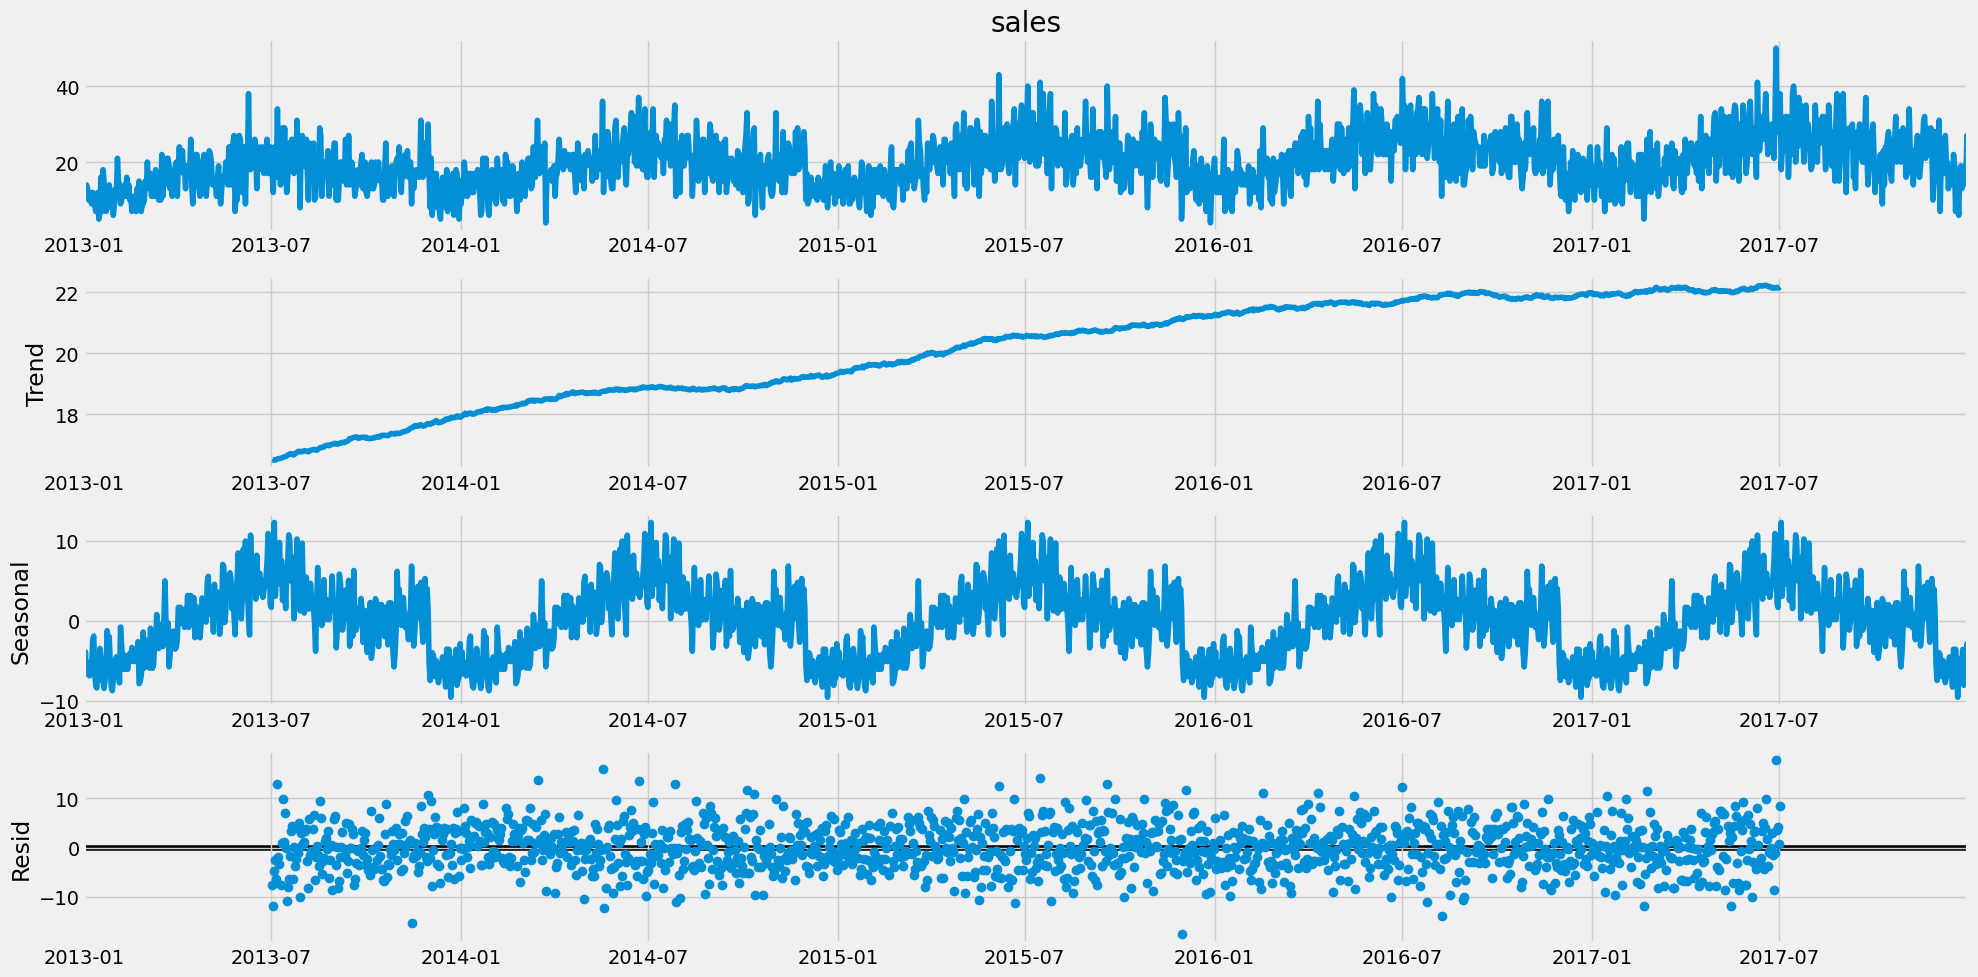

In [50]:
decomposition = seasonal_decompose(buf.sales.dropna(), period=365)
figure = decomposition.plot()
plt.show()

In [51]:
tr_start, tr_end = '2014-01-01', '2017-09-30'
te_start, te_end = '2017-10-01', '2017-12-31'

x0 = buf['sales'][tr_start:tr_end].dropna()
x1 = buf['sales'][te_start:te_end].dropna()

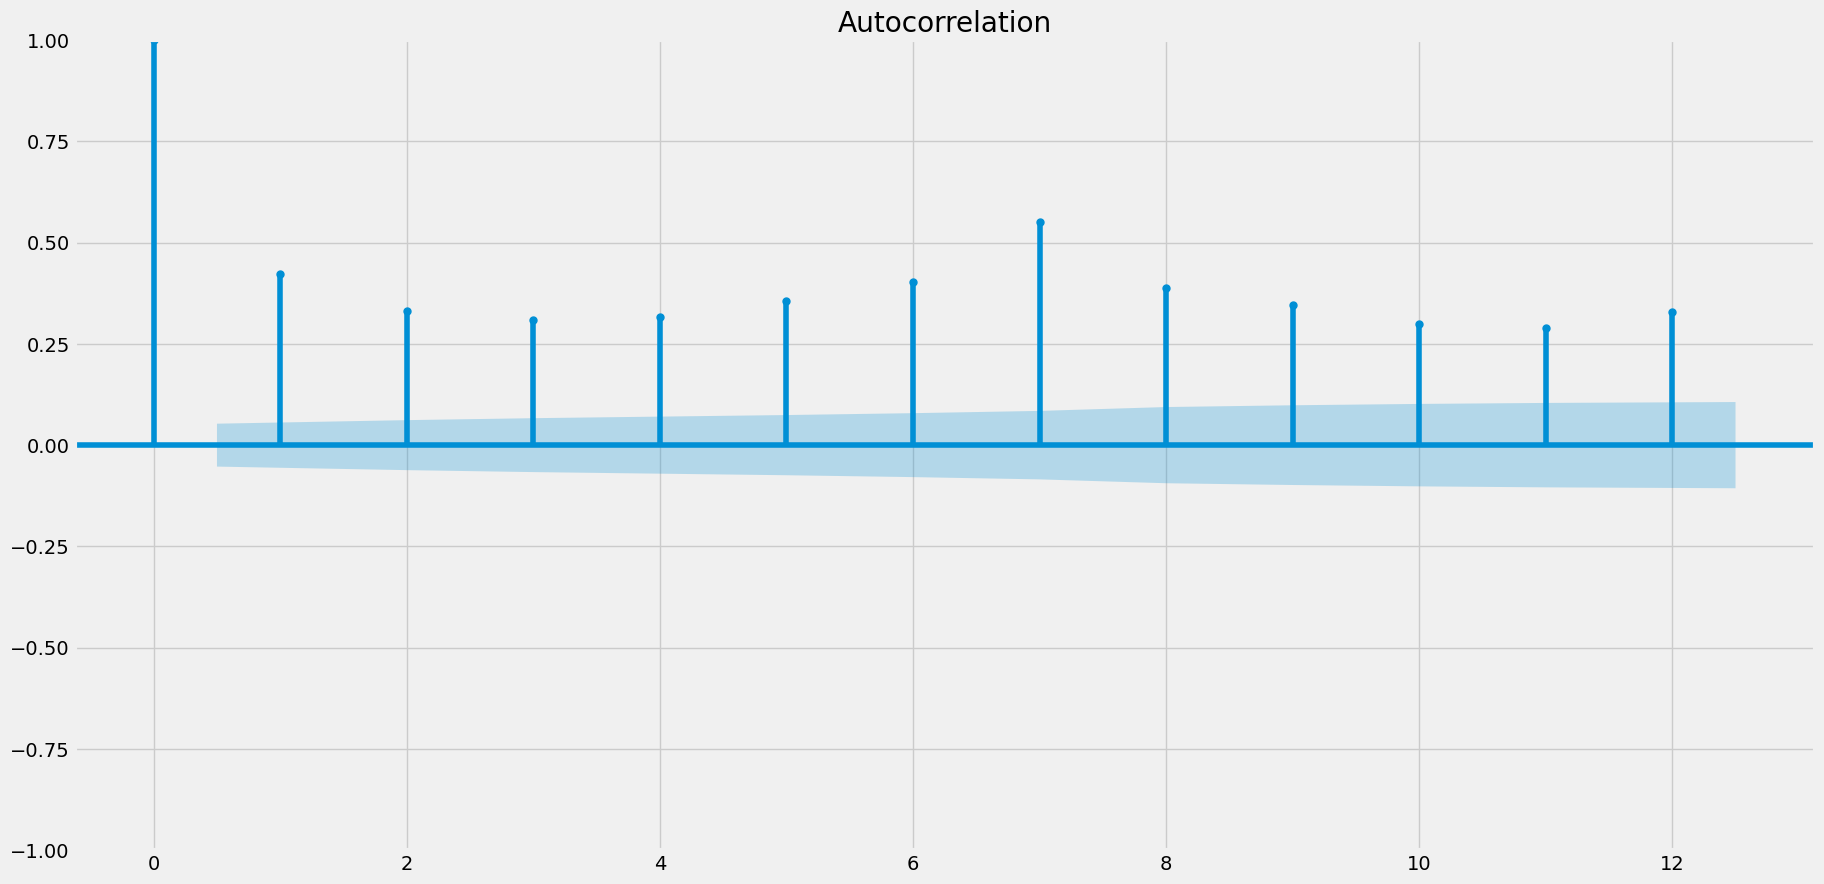

In [52]:
plot_acf(x0, lags=12)
plt.show()

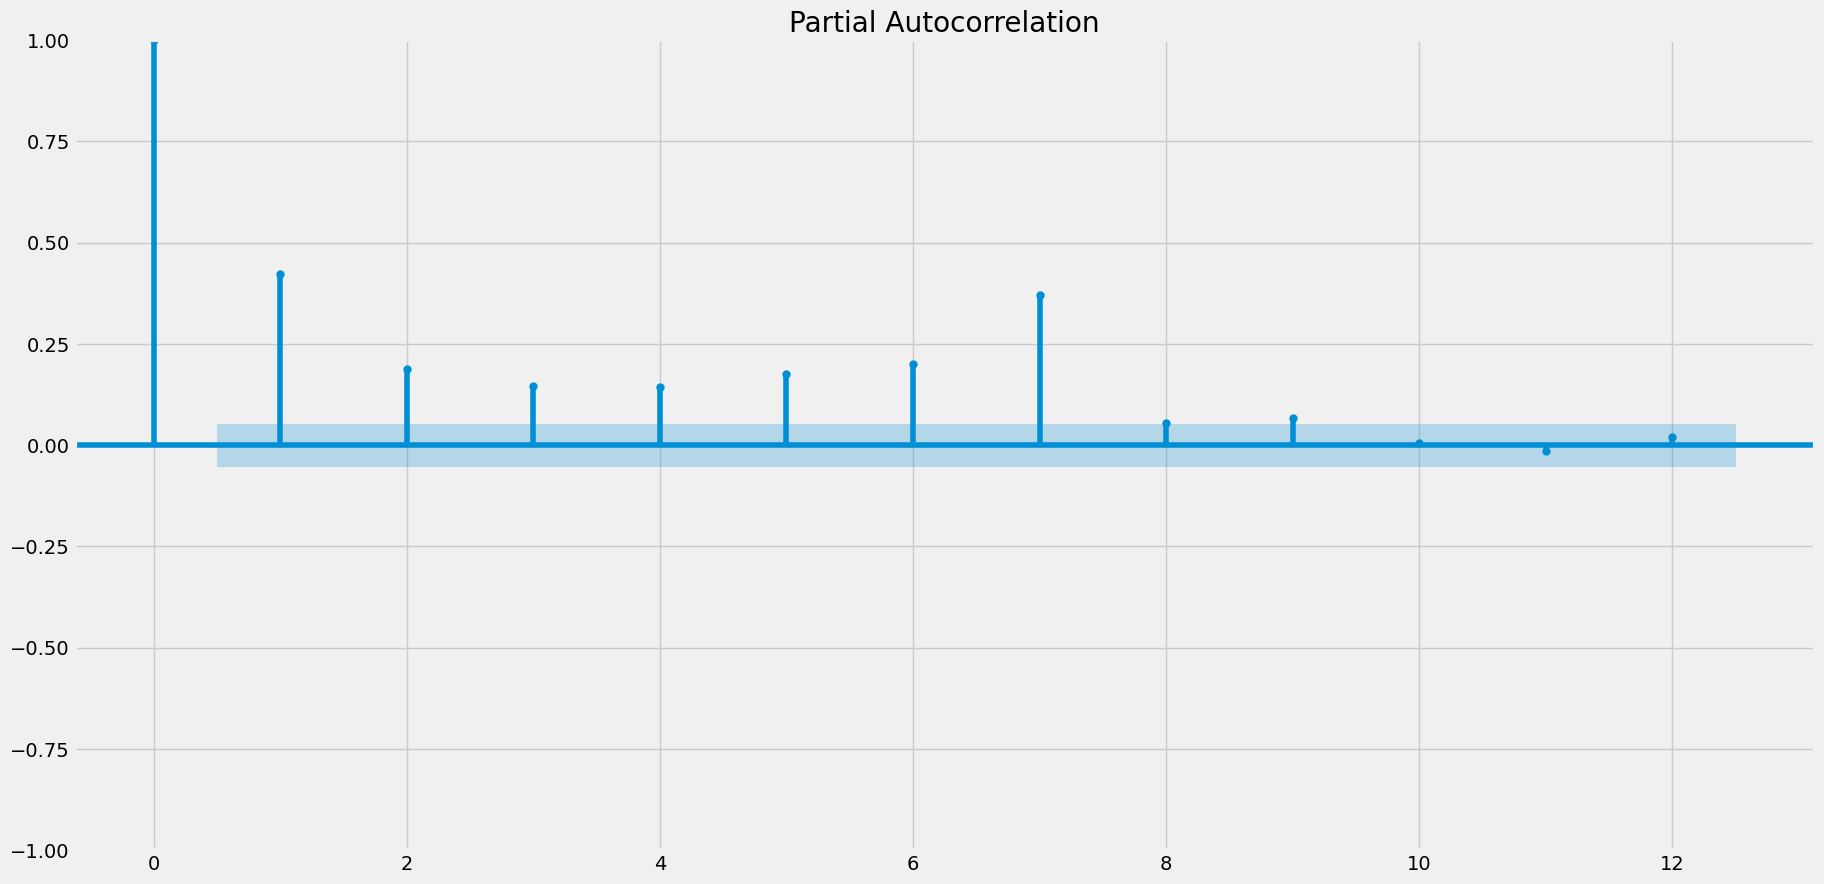

In [53]:
plot_pacf(x0, lags=12)
plt.show()

In [54]:
model_autoarima = auto_arima(x0, start_p=7, start_q=7, test='adf', max_p=7, max_q=7, m=7, d=1, seasonal=True, start_P=1, D=1, trace=True, error_action='ignore', 
    suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(1,1,1)[7]             : AIC=inf, Time=6.85 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=9783.794, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=9076.573, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=9482.428, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=8942.628, Time=0.38 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.36 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=9292.960, Time=0.17 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=8771.023, Time=0.41 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=8902.831, Time=0.14 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=3.09 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.64 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=8677.203, Time=0.56 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=8810.188, Time=0.30 s

In [55]:
print(model_autoarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1369
Model:             SARIMAX(6, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -4277.811
Date:                           Tue, 25 Oct 2022   AIC                           8573.621
Time:                                   20:13:35   BIC                           8620.565
Sample:                               01-01-2014   HQIC                          8591.194
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8487      0.028    -30.292      0.000      -0.904      -0.794
ar.L2         -0.7342      0.036    -20.322

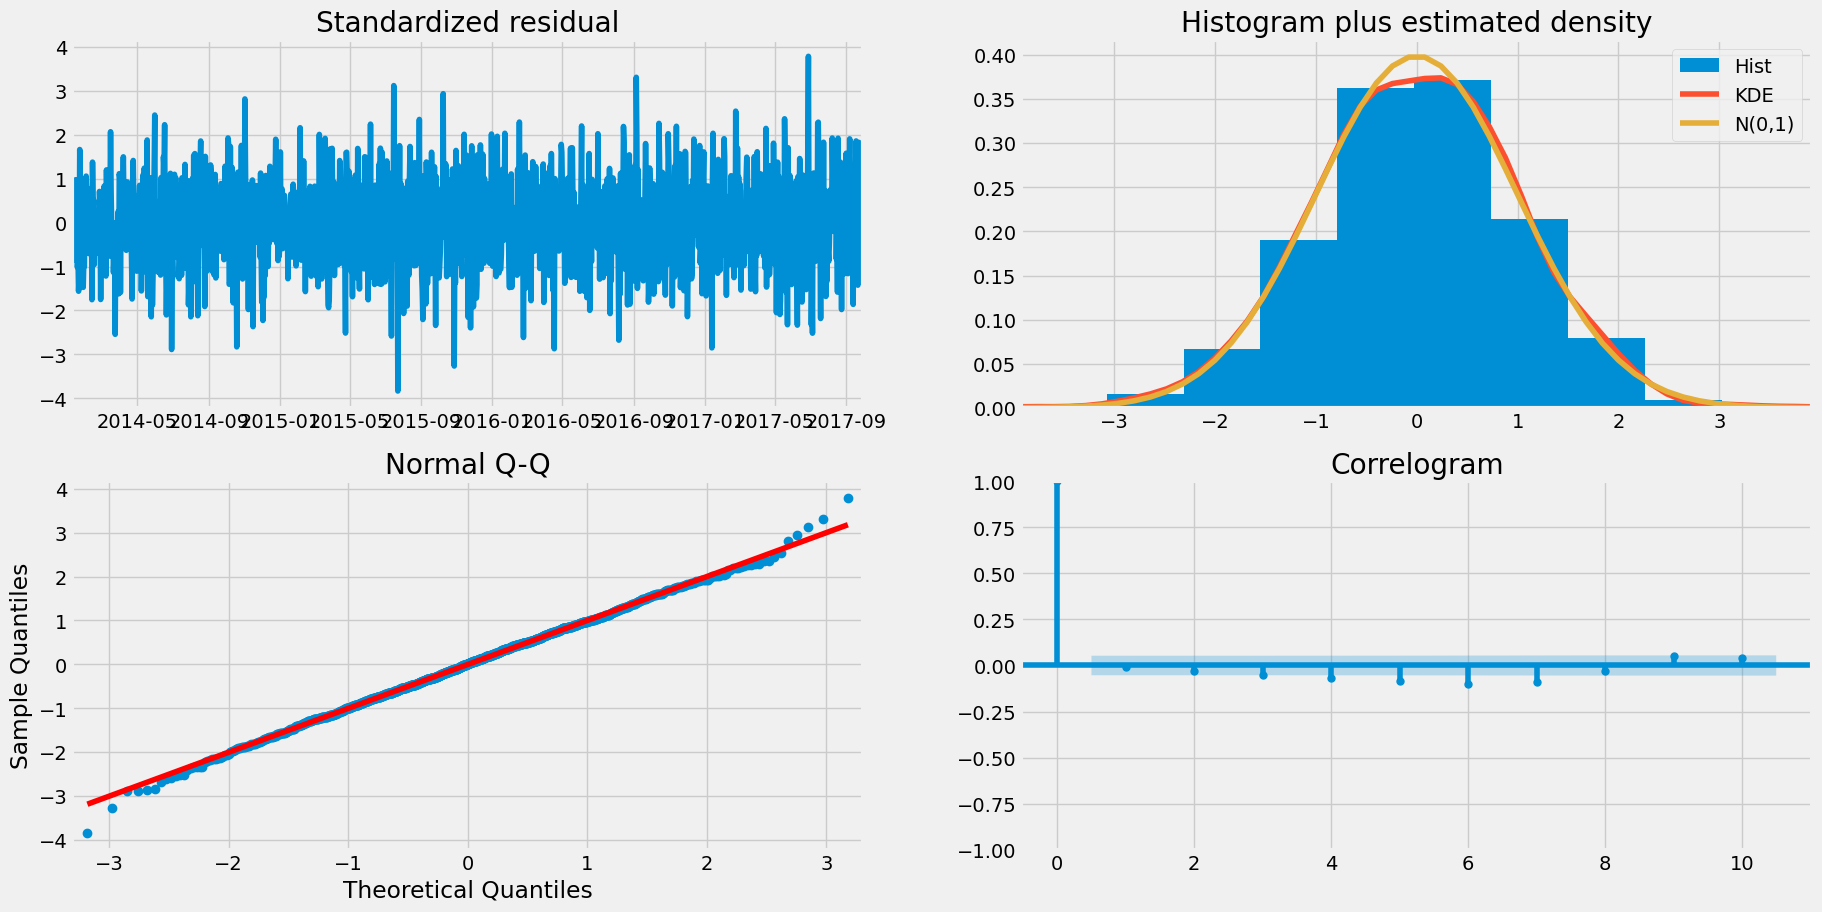

In [57]:
model_autoarima.plot_diagnostics()
plt.show()

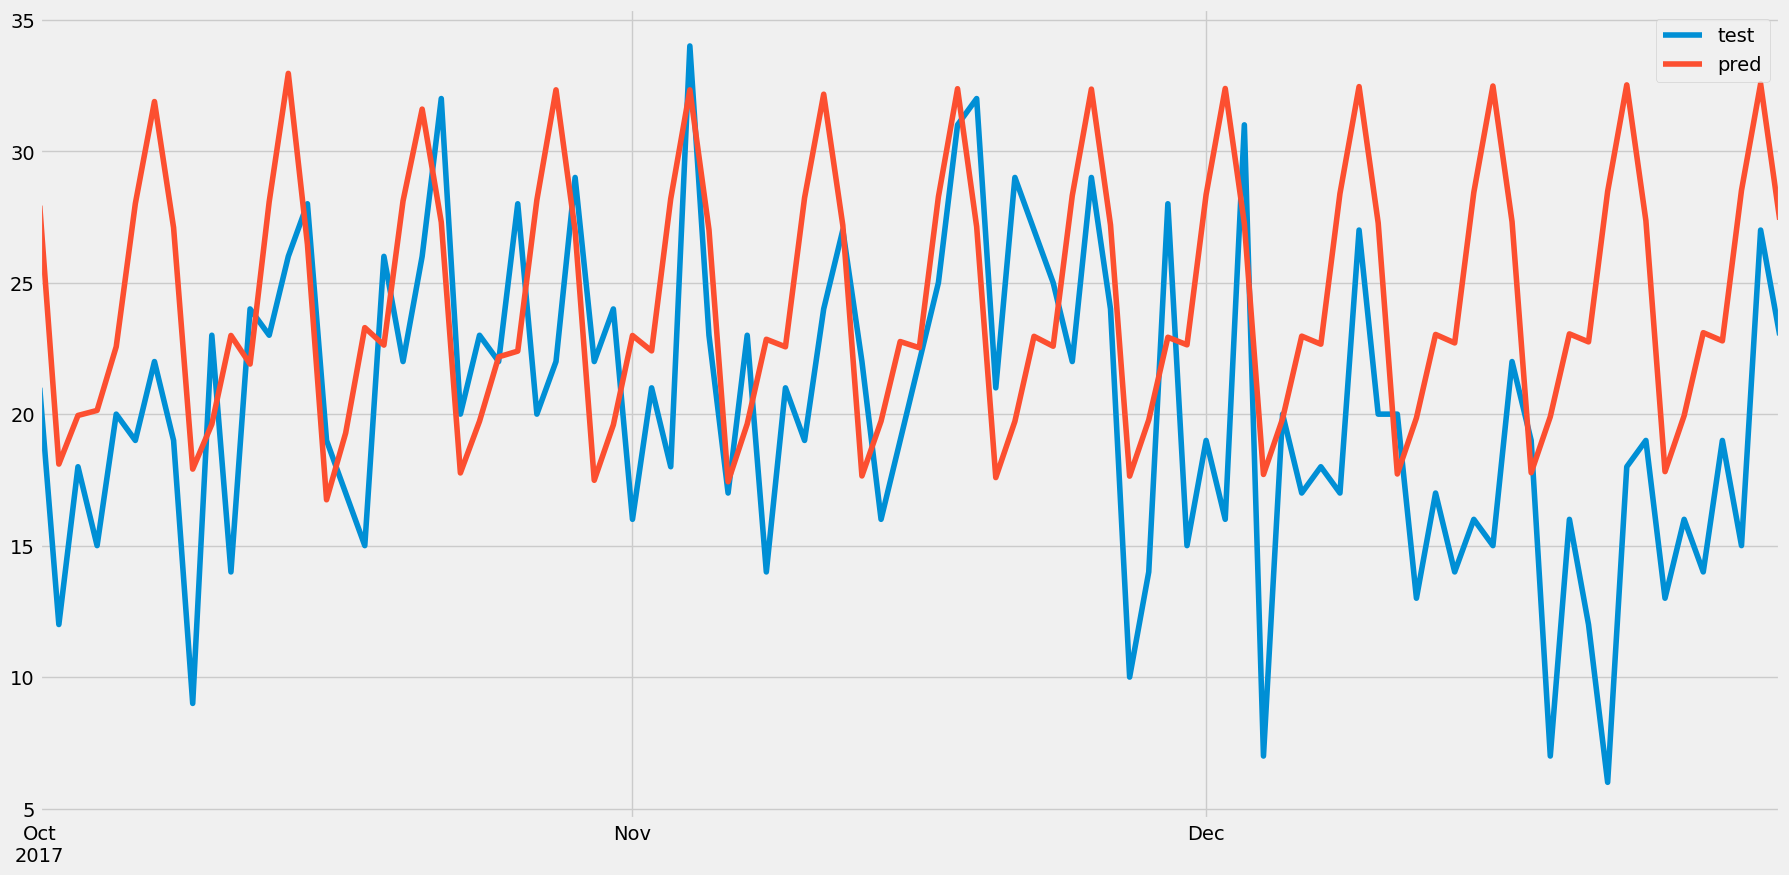

In [58]:
pred = model_autoarima.predict(x1.shape[0])
pd.DataFrame({'test': x1, 'pred': pred}).plot()
plt.show()

Using Exogenous Features to make forecasts  
Problem: Tata Steel VWAP Forecasts

In [108]:
df = pd.read_csv("datasets/TATASTEEL.csv")
df.set_index("Date", inplace=True, drop=False)

<AxesSubplot: xlabel='Date'>

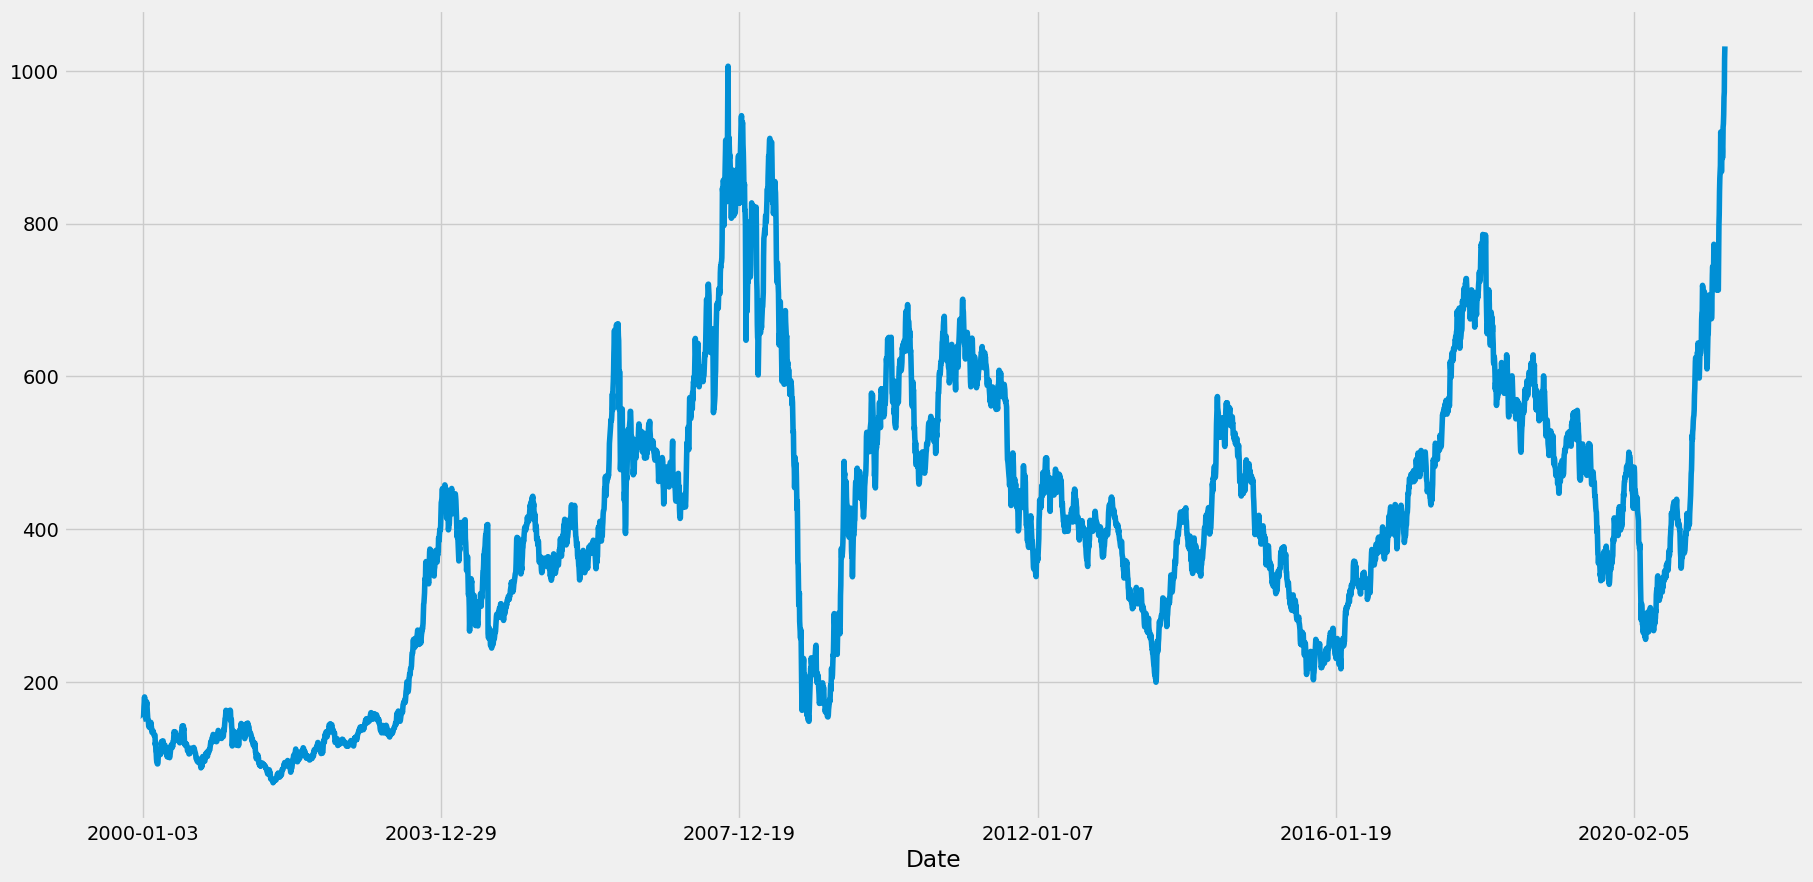

In [109]:
df.VWAP.plot()

In [110]:
lag_features = ['High', 'Low', 'Volume']
window_size = 3
df_rolled = df[lag_features].rolling(window=window_size, min_periods=0)
df_mean = df_rolled.mean().shift(1)
df_std  = df_rolled.std().shift(1)

In [111]:
feature_list = []
for feature in lag_features:
    df[feature + '_mean_lag_' + str(window_size)] = df_mean[feature].values
    df[feature + '_std_lag_' + str(window_size)]  = df_std[feature].values
    feature_list.append(feature + '_mean_lag_' + str(window_size))
    feature_list.append(feature + '_std_lag_' + str(window_size))

df.fillna(df.mean(), inplace=True)
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag_3,High_std_lag_3,Low_mean_lag_3,Low_std_lag_3,Volume_mean_lag_3,Volume_std_lag_3
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,TISCO,EQ,142.35,148.00,153.20,146.10,152.50,152.45,150.92,...,3.023164e+13,93969.26873,1.550750e+06,0.260951,410.926164,6.542085,396.236813,6.939031,6.154572e+06,1.710971e+06
2000-01-04,2000-01-04,TISCO,EQ,152.45,150.10,153.00,143.05,151.95,150.80,151.03,...,2.348785e+13,93969.26873,1.550750e+06,0.260951,153.200000,6.542085,146.100000,6.939031,2.003185e+06,1.710971e+06
2000-01-05,2000-01-05,TISCO,EQ,150.80,144.60,162.90,144.60,158.00,156.55,156.85,...,6.023364e+13,93969.26873,1.550750e+06,0.260951,153.100000,0.141421,144.575000,2.156676,1.779160e+06,3.168185e+05
2000-01-06,2000-01-06,TISCO,EQ,156.55,158.95,169.10,158.95,169.00,168.25,167.61,...,4.291530e+13,93969.26873,1.550750e+06,0.260951,156.366667,5.658916,144.583333,1.525068,2.466202e+06,1.210894e+06
2000-01-07,2000-01-07,TISCO,EQ,168.25,173.40,179.00,166.30,170.55,171.95,173.89,...,6.332459e+13,93969.26873,1.550750e+06,0.260951,161.666667,8.120550,148.866667,8.766746,2.651956e+06,1.145319e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,2021-04-26,TATASTEEL,EQ,925.60,935.00,956.00,930.05,942.50,940.75,942.98,...,2.002407e+15,274958.00000,4.584617e+06,0.215900,929.800000,21.068519,896.600000,14.380282,2.452350e+07,7.496382e+06
2021-04-27,2021-04-27,TATASTEEL,EQ,940.75,948.30,983.00,944.30,982.00,977.75,965.43,...,2.404346e+15,331493.00000,3.575969e+06,0.143600,946.550000,8.778240,912.616667,16.579003,2.596335e+07,5.436098e+06
2021-04-28,2021-04-28,TATASTEEL,EQ,977.75,985.00,986.00,962.00,971.00,971.40,972.08,...,1.987700e+15,255599.00000,3.550908e+06,0.173700,961.333333,19.553346,928.366667,16.838225,2.363059e+07,2.076155e+06


In [112]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]
feature_list


['High_mean_lag_3',
 'High_std_lag_3',
 'Low_mean_lag_3',
 'Low_std_lag_3',
 'Volume_mean_lag_3',
 'Volume_std_lag_3']

In [114]:
model_arima = auto_arima(df_train.VWAP, df_train[feature_list], m=7, max_p=2, max_q=2, max_P=1, max_Q=1, trace=True, error_action='ignore', suppress_warnings=True)
model_arima.fit(df_train.VWAP, exogenous=df_train[feature_list])

forecast = model_arima.predict(n_periods=len(df_valid),X=df_valid[feature_list])
df_valid["Forecast_ARIMAX"] = forecast.values

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=35921.269, Time=100.45 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=38986.123, Time=1.20 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=36339.065, Time=60.83 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=38867.406, Time=49.29 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=74270.674, Time=0.87 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=35919.583, Time=83.03 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=35920.888, Time=14.71 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=35919.194, Time=74.31 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=35915.836, Time=60.43 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=35917.349, Time=13.97 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=35917.847, Time=83.22 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=35916.140, Time=82.54 sec
 ARIMA(0,0,2)(1,0,0)[7] intercept   : AIC=36040.051, Time=60.68 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=36045.303, Time=55.00 sec
 ARIMA

/Users/mananshah/miniforge3/envs/ts_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/var/folders/b9/d6hxbcwn2b57xb2rz_lg4h0w0000gn/T/ipykernel_2559/390567140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_ARIMAX"] = forecast.values


In [104]:
df_valid["Forecast_ARIMAX"] = forecast.values

/var/folders/b9/d6hxbcwn2b57xb2rz_lg4h0w0000gn/T/ipykernel_2559/3869237603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_ARIMAX"] = forecast.values


In [118]:
df_valid["Forecast_ARIMAX"].describe()

count    577.000000
mean     489.406784
std       19.544435
min      456.407094
25%      472.432233
50%      489.020038
75%      506.190266
max      524.033197
Name: Forecast_ARIMAX, dtype: float64

In [116]:
### Using Prophet
df = df_train[['Date', 'VWAP']].rename(columns={"Date": "ds", "VWAP": "y"})

model_prophet = Prophet()

for f in feature_list:
    df[f] = df_train[f]
    model_prophet.add_regressor(f)

model_prophet.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -74.4543


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17575.6     0.0029479       6415.16           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17601.6   0.000305328       553.787           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17607.1   0.000242477       497.345           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       17608.1   0.000177588       295.883           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17609.1   7.35681e-05       665.693      0.7762      0.7762      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

/var/folders/b9/d6hxbcwn2b57xb2rz_lg4h0w0000gn/T/ipykernel_2559/4250701121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_Prophet"] = forecast.yhat.values


<AxesSubplot: xlabel='Date'>

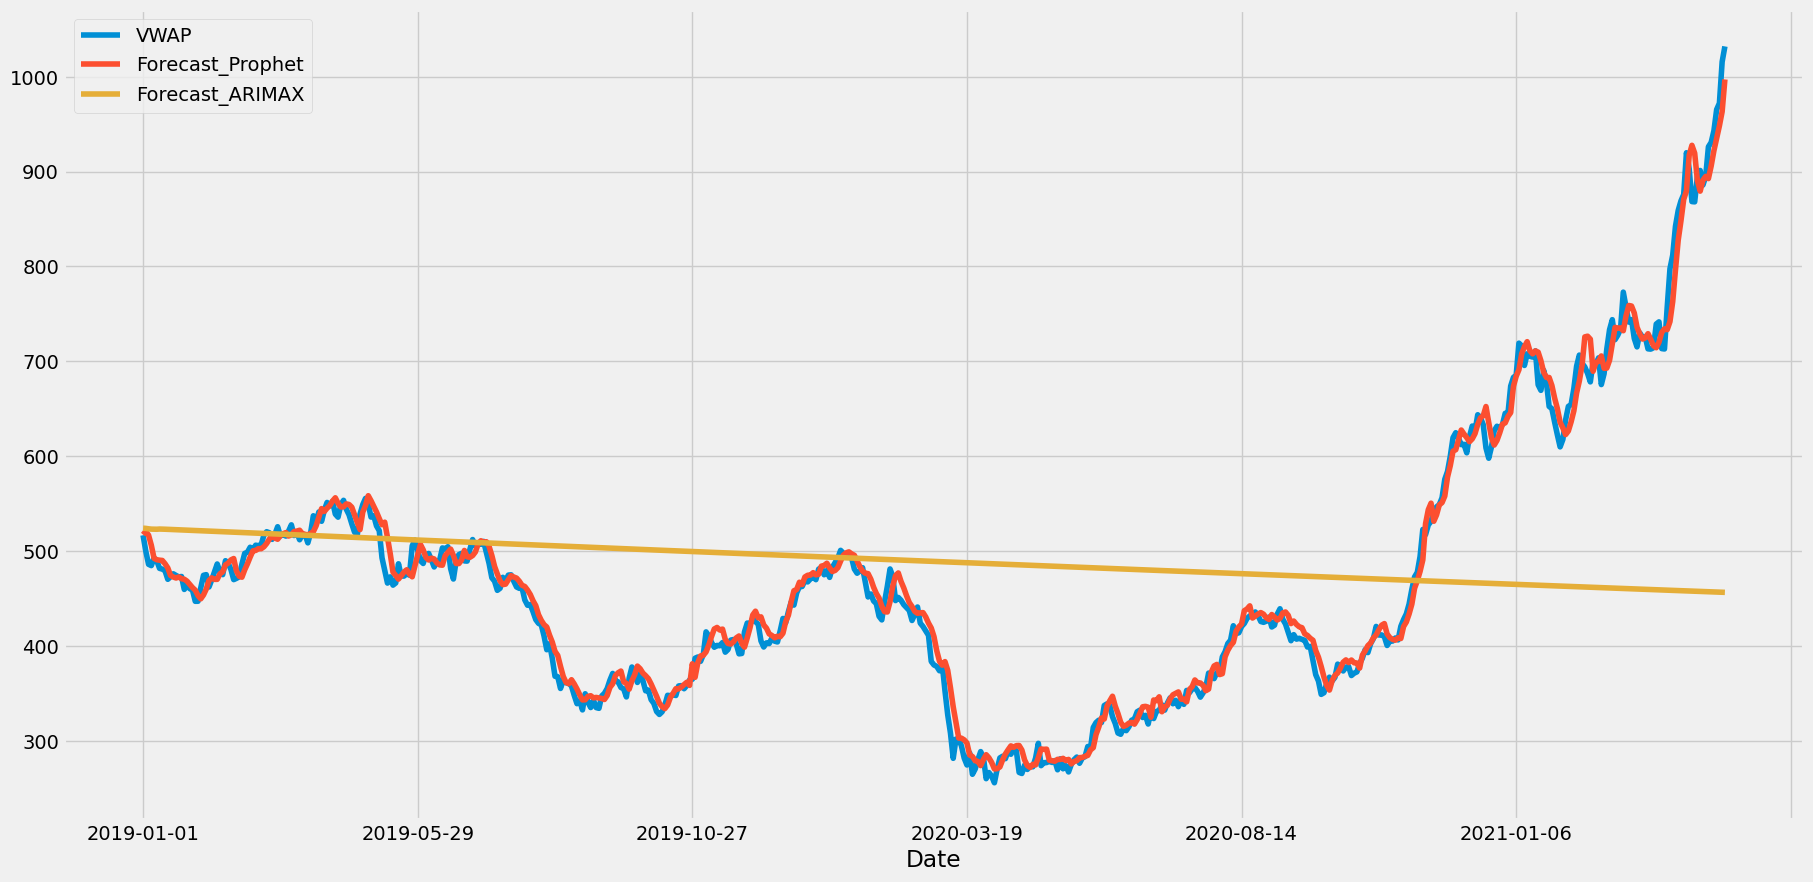

In [117]:
forecast = model_prophet.predict(df_valid[["Date", "VWAP"]+ feature_list].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values
df_valid[["VWAP", "Forecast_Prophet", "Forecast_ARIMAX"]].plot()

In [82]:
def friendly_rmse(x,y):
    return np.round(np.sqrt(mean_squared_error(x, y))  ,4)

df_valid.dropna(inplace=True)
print("RMSE of Auto ARIMAX:", friendly_rmse(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("RMSE of Prophet:", friendly_rmse(df_valid.VWAP, df_valid.Forecast_Prophet))

/var/folders/b9/d6hxbcwn2b57xb2rz_lg4h0w0000gn/T/ipykernel_2559/1568317079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.dropna(inplace=True)


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [91]:
df_valid

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Deliverable Volume,%Deliverble,High_mean_lag_3,High_std_lag_3,Low_mean_lag_3,Low_std_lag_3,Volume_mean_lag_3,Volume_std_lag_3,Forecast_ARIMAX,Forecast_Prophet
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2019-01-01,TATASTEEL,EQ,521.05,524.0,524.50,513.55,515.60,515.75,516.59,...,718976.0,0.1742,520.416667,4.308229,509.733333,5.810838,6.430050e+06,1.478261e+06,NaN,517.262840
2019-01-02,2019-01-02,TATASTEEL,EQ,515.75,506.0,506.80,492.00,492.50,493.65,499.63,...,3527471.0,0.3003,521.983333,4.798524,512.600000,4.157223,6.133798e+06,1.924701e+06,NaN,520.591766
2019-01-03,2019-01-03,TATASTEEL,EQ,493.65,493.0,493.15,480.25,480.90,481.25,485.96,...,3565334.0,0.2635,518.766667,10.366452,507.250000,13.273187,7.947112e+06,3.809623e+06,NaN,516.680737
2019-01-04,2019-01-04,TATASTEEL,EQ,481.25,481.0,492.85,479.55,492.70,487.65,484.60,...,3118466.0,0.2976,508.150000,15.718540,495.266667,16.888630,9.802822e+06,4.994829e+06,NaN,506.081309
2019-01-07,2019-01-07,TATASTEEL,EQ,487.65,495.4,501.00,483.90,485.65,485.50,492.72,...,2161511.0,0.2571,497.600000,7.968846,483.933333,6.994700,1.192012e+07,1.533752e+06,NaN,492.295703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,2021-04-26,TATASTEEL,EQ,925.60,935.0,956.00,930.05,942.50,940.75,942.98,...,4584617.0,0.2159,929.800000,21.068519,896.600000,14.380282,2.452350e+07,7.496382e+06,NaN,922.034694
2021-04-27,2021-04-27,TATASTEEL,EQ,940.75,948.3,983.00,944.30,982.00,977.75,965.43,...,3575969.0,0.1436,946.550000,8.778240,912.616667,16.579003,2.596335e+07,5.436098e+06,NaN,935.040298
2021-04-28,2021-04-28,TATASTEEL,EQ,977.75,985.0,986.00,962.00,971.00,971.40,972.08,...,3550908.0,0.1737,961.333333,19.553346,928.366667,16.838225,2.363059e+07,2.076155e+06,NaN,948.173422


In [93]:
df_valid["Forecast_ARIMAX"]

Date
2019-01-01   NaN
2019-01-02   NaN
2019-01-03   NaN
2019-01-04   NaN
2019-01-07   NaN
              ..
2021-04-26   NaN
2021-04-27   NaN
2021-04-28   NaN
2021-04-29   NaN
2021-04-30   NaN
Name: Forecast_ARIMAX, Length: 577, dtype: float64